## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with analyzing the data, developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Please read the instructions carefully before starting the project.**

**Note**: If the free-tier GPU of Google Colab is not accessible (due to unavailability or exhaustion of daily limit or other reasons), the following steps can be taken:

1. Wait for 12-24 hours until the GPU is accessible again or the daily usage limits are reset.

2. Switch to a different Google account and resume working on the project from there.

3. Try using the CPU runtime:
    - To use the CPU runtime, click on *Runtime* => *Change runtime type* => *CPU* => *Save*
    - One can also click on the *Continue without GPU* option to switch to a CPU runtime (kindly refer to the snapshot below)
    - The instructions for running the code on the CPU are provided in the respective sections of the notebook.

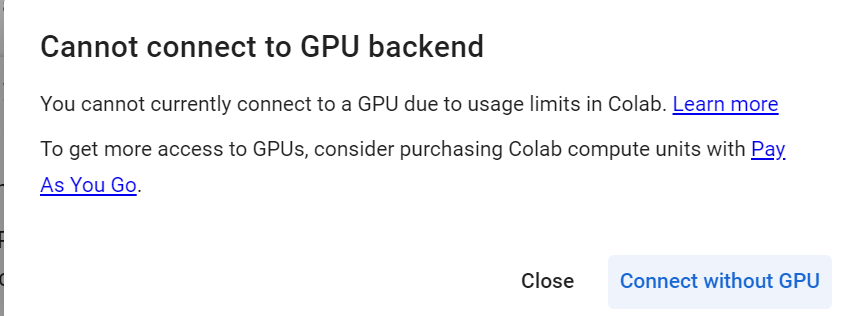

## **Installing and Importing Necessary Libraries**

In [ ]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install -U sentence-transformers gensim transformers tqdm -q

## **Loading the dataset**

In [ ]:
# Importing libraries to manipulate and analyze data
import pandas as pd  # pandas for handling data frames and datasets
import numpy as np   # numpy for numerical operations on arrays and matrices

# Importing libraries for data visualization
import matplotlib.pyplot as plt  # matplotlib for creating static visualizations like plots and graphs
import seaborn as sns          # seaborn for statistical data visualization (more advanced than matplotlib)

# Importing time-related functions for measuring execution time and managing timestamps
import time  # time module is used for timing the execution of certain tasks (e.g., measuring how long an operation takes)

# Importing JSON parsing library for working with JSON data format
import json  # json module to parse and manipulate JSON data structures

# Importing machine learning models, tools, and evaluation metrics
from sklearn.ensemble import GradientBoostingClassifier  # Gradient Boosting Machine for classification tasks
from sklearn.ensemble import RandomForestClassifier     # Random Forest Classifier for building decision trees
from sklearn.tree import DecisionTreeClassifier         # Decision Tree Classifier for building a single tree model

from sklearn.model_selection import GridSearchCV  # GridSearchCV for hyperparameter tuning and cross-validation
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score  # Metrics for evaluating the model's performance

# Importing libraries for working with word embeddings (converting words to vector representations)
from gensim.models import Word2Vec  # Word2Vec for creating word embeddings based on word context
from gensim.models import KeyedVectors  # KeyedVectors to handle vectorized word embeddings
from gensim.scripts.glove2word2vec import glove2word2vec  # Utility to convert GloVe embeddings to Word2Vec format

# Importing libraries for transformer models used in NLP (natural language processing)
import torch  # PyTorch for deep learning models, such as transformers
from sentence_transformers import SentenceTransformer  # SentenceTransformer for encoding sentences into embeddings

# Importing library for progress bars to track the execution progress of tasks
from tqdm import tqdm  # tqdm for showing a progress bar during iterations, useful in long-running loops
tqdm.pandas()  # Enables progress bars in pandas operations (like `apply` method)

# To ignore unnecessary warnings that might clutter the output
import warnings  # warnings module to manage warnings during code execution
warnings.filterwarnings('ignore')  # Disable warnings from appearing in the output


## **Data Overview**

In [ ]:
# # uncomment and run the following code if Google Colab is being used and the dataset is in Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
stock_news = pd.read_csv("/content/drive/MyDrive/AIML_Project5/stock_news.csv")

In [ ]:
#Creating a copy of the dataset
stock = stock_news.copy()

## Lets explore the dataset

In [ ]:
stock.head(2)

,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.740002,42.244999,41.482498,40.246914,130672400,-1


In [ ]:
stock.sample(5)

,Date,News,Open,High,Low,Close,Volume,Label
336,2019-04-26,"Sony, the Japanese technology giant, announce...",51.224998,51.250000,50.529999,49.589897,74596400,0
185,2019-02-12,Akamai Technologies reported stronger than pr...,66.817497,67.062500,65.862503,64.805229,94487200,1
276,2019-03-26,Goldman Sachs has announced a credit card par...,47.915001,48.220001,46.145000,45.339684,199202000,0
165,2019-01-31,The United Arab Emirates (UAE) denied on Thurs...,41.527500,42.250000,41.139999,40.227589,162958400,0
315,2019-04-17,"Facebook, aiming to compete with Alexa, Siri,...",49.884998,50.845001,49.652500,49.305897,115627200,-1


In [ ]:
stock.tail(1)

,Date,News,Open,High,Low,Close,Volume,Label
348,2019-04-30,"In the first quarter, South Korea's Samsung E...",50.764999,50.849998,49.7775,48.70879,186139600,0


In [ ]:
stock.shape

(349, 8)

In [ ]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    349 non-null    object 
 1   News    349 non-null    object 
 2   Open    349 non-null    float64
 3   High    349 non-null    float64
 4   Low     349 non-null    float64
 5   Close   349 non-null    float64
 6   Volume  349 non-null    int64  
 7   Label   349 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 21.9+ KB


In [ ]:
stock['Date'] = pd.to_datetime(stock['Date'], errors='coerce')

### Lets check the data type of date

In [ ]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    349 non-null    datetime64[ns]
 1   News    349 non-null    object        
 2   Open    349 non-null    float64       
 3   High    349 non-null    float64       
 4   Low     349 non-null    float64       
 5   Close   349 non-null    float64       
 6   Volume  349 non-null    int64         
 7   Label   349 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 21.9+ KB


### Lets check the stats

In [ ]:
stock.describe()

,Date,Open,High,Low,Close,Volume,Label
count,349,349.000000,349.000000,349.000000,349.000000,3.490000e+02,349.000000
mean,2019-02-16 16:05:30.085959936,46.229233,46.700458,45.745394,44.926317,1.289482e+08,-0.054441
min,2019-01-02 00:00:00,37.567501,37.817501,37.305000,36.254131,4.544800e+07,-1.000000
25%,2019-01-14 00:00:00,41.740002,42.244999,41.482498,40.246914,1.032720e+08,-1.000000
50%,2019-02-05 00:00:00,45.974998,46.025002,45.639999,44.596924,1.156272e+08,0.000000
75%,2019-03-22 00:00:00,50.707500,50.849998,49.777500,49.110790,1.511252e+08,0.000000
max,2019-04-30 00:00:00,66.817497,67.062500,65.862503,64.805229,2.444392e+08,1.000000
std,NaN,6.442817,6.507321,6.391976,6.398338,4.317031e+07,0.715119


### Check duplicate values

In [ ]:
stock.duplicated().sum()

0

### Check null values

In [ ]:
stock.isnull().sum()

,0
Date,0
News,0
Open,0
High,0
Low,0
Close,0
Volume,0
Label,0


## **Exploratory Data Analysis**

### Univariate Analysis

* Distribution of individual variables
* Compute and check the distribution of the length of news content

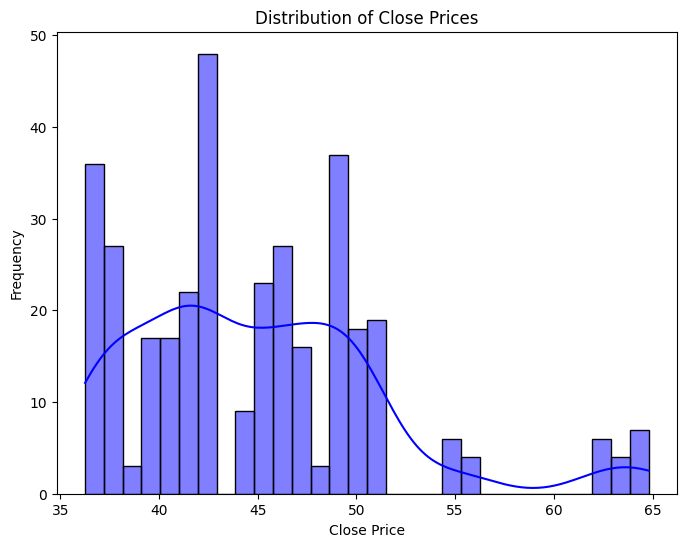

In [ ]:
# Plotting the distribution of 'Close' prices
plt.figure(figsize=(8, 6))
sns.histplot(stock['Close'], kde=True, color='blue', bins=30)
plt.title('Distribution of Close Prices')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.show()


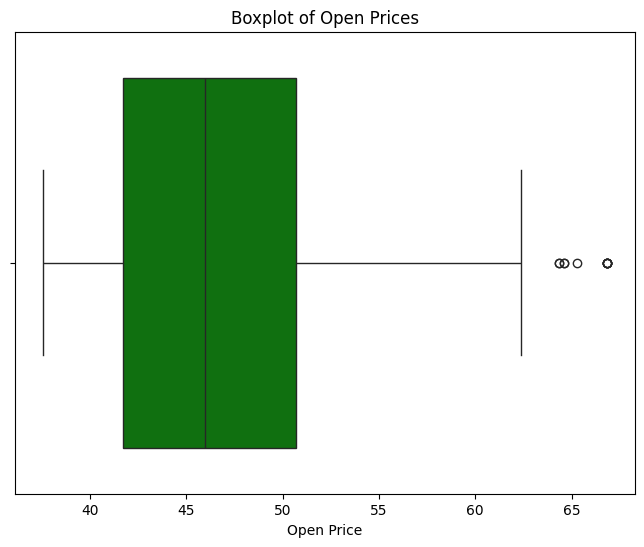

In [ ]:
# Plotting the boxplot for 'Open' prices
plt.figure(figsize=(8, 6))
sns.boxplot(x=stock['Open'], color='green')
plt.title('Boxplot of Open Prices')
plt.xlabel('Open Price')
plt.show()


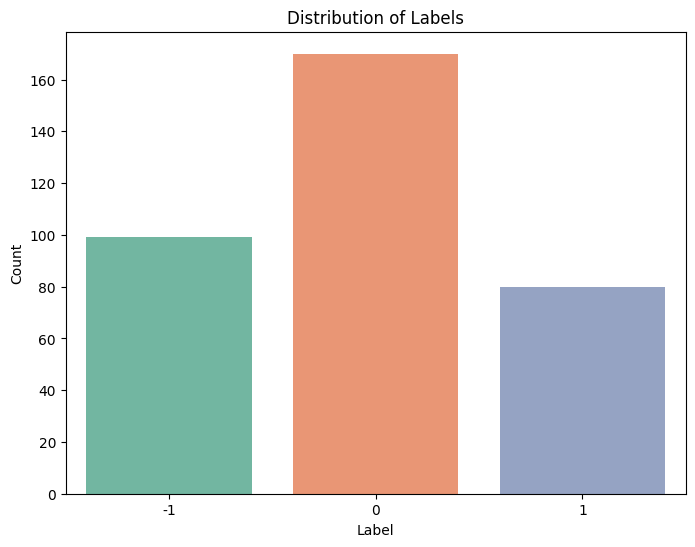

In [ ]:
# Countplot showing distribution of 'Label' categories (e.g., Positive, Negative, Neutral)
plt.figure(figsize=(8, 6))
sns.countplot(data=stock, x='Label', palette='Set2')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


### Imbalanced Data
imbalanced data can significantly affect model performance, especially in classification tasks. When the data is imbalanced, the model tends to be biased towards the majority class because it sees more examples of that class, leading to poor generalization on the minority class.

In this case, if the dataset contains more neutral news articles compared to positive or negative ones, the model may have trouble identifying the less frequent sentiment classes (positive or negative sentiment) and could perform poorly when predicting these classes.



"Approximately 50% of the news is neutral, while 30-20% of the news is classified as negative and positive."

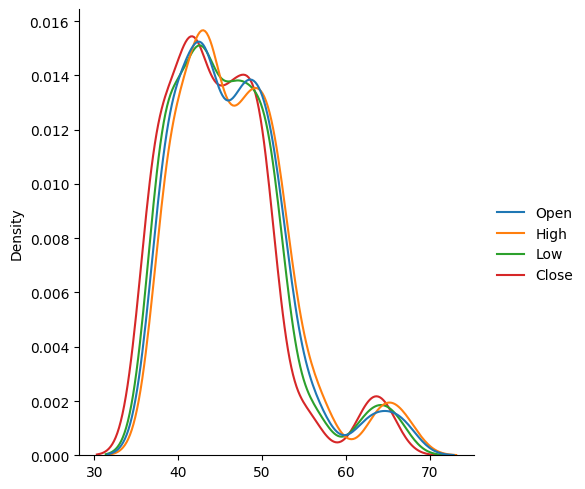

In [ ]:
sns.displot(
    data=stock[['Open', 'High', 'Low', 'Close']],
    kind="kde",
    palette="tab10"
)

<Axes: xlabel='Volume', ylabel='Count'>

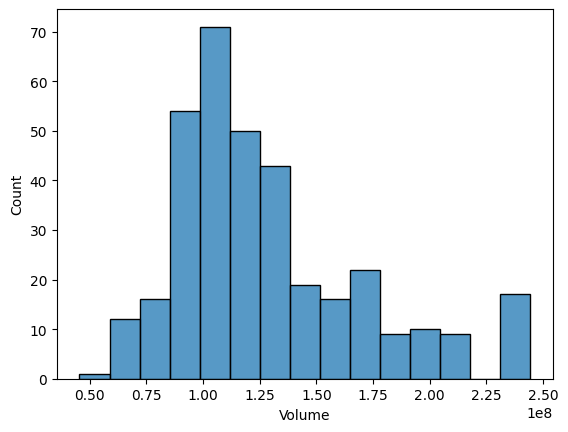

In [ ]:
sns.histplot(
    data=stock,
    x='Volume'
)

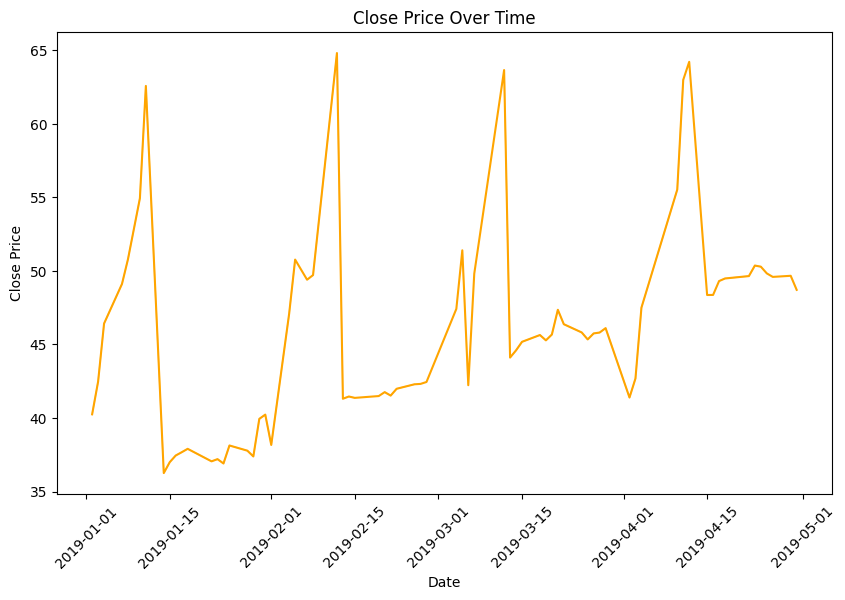

In [ ]:
# Plotting the 'Close' prices over time (Date)
plt.figure(figsize=(10, 6))
sns.lineplot(data=stock, x='Date', y='Close', color='orange')
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.show()


### Bivariate Analysis

* Correlation
* Sentiment Polarity vs Price
* Date vs Price

**Note**: The above points are listed to provide guidance on how to approach bivariate analysis. Analysis has to be done beyond the above listed points to get maximum scores.

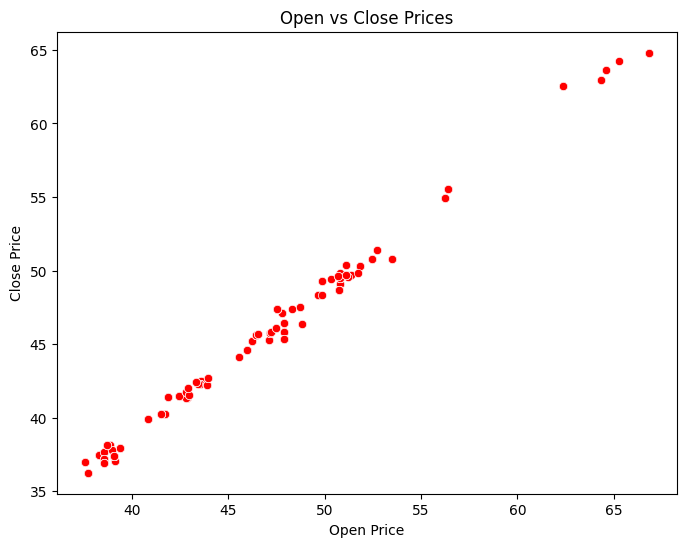

In [ ]:
# Scatter plot showing relationship between 'Open' and 'Close' prices
plt.figure(figsize=(8, 6))
sns.scatterplot(data=stock, x='Open', y='Close', color='red')
plt.title('Open vs Close Prices')
plt.xlabel('Open Price')
plt.ylabel('Close Price')
plt.show()

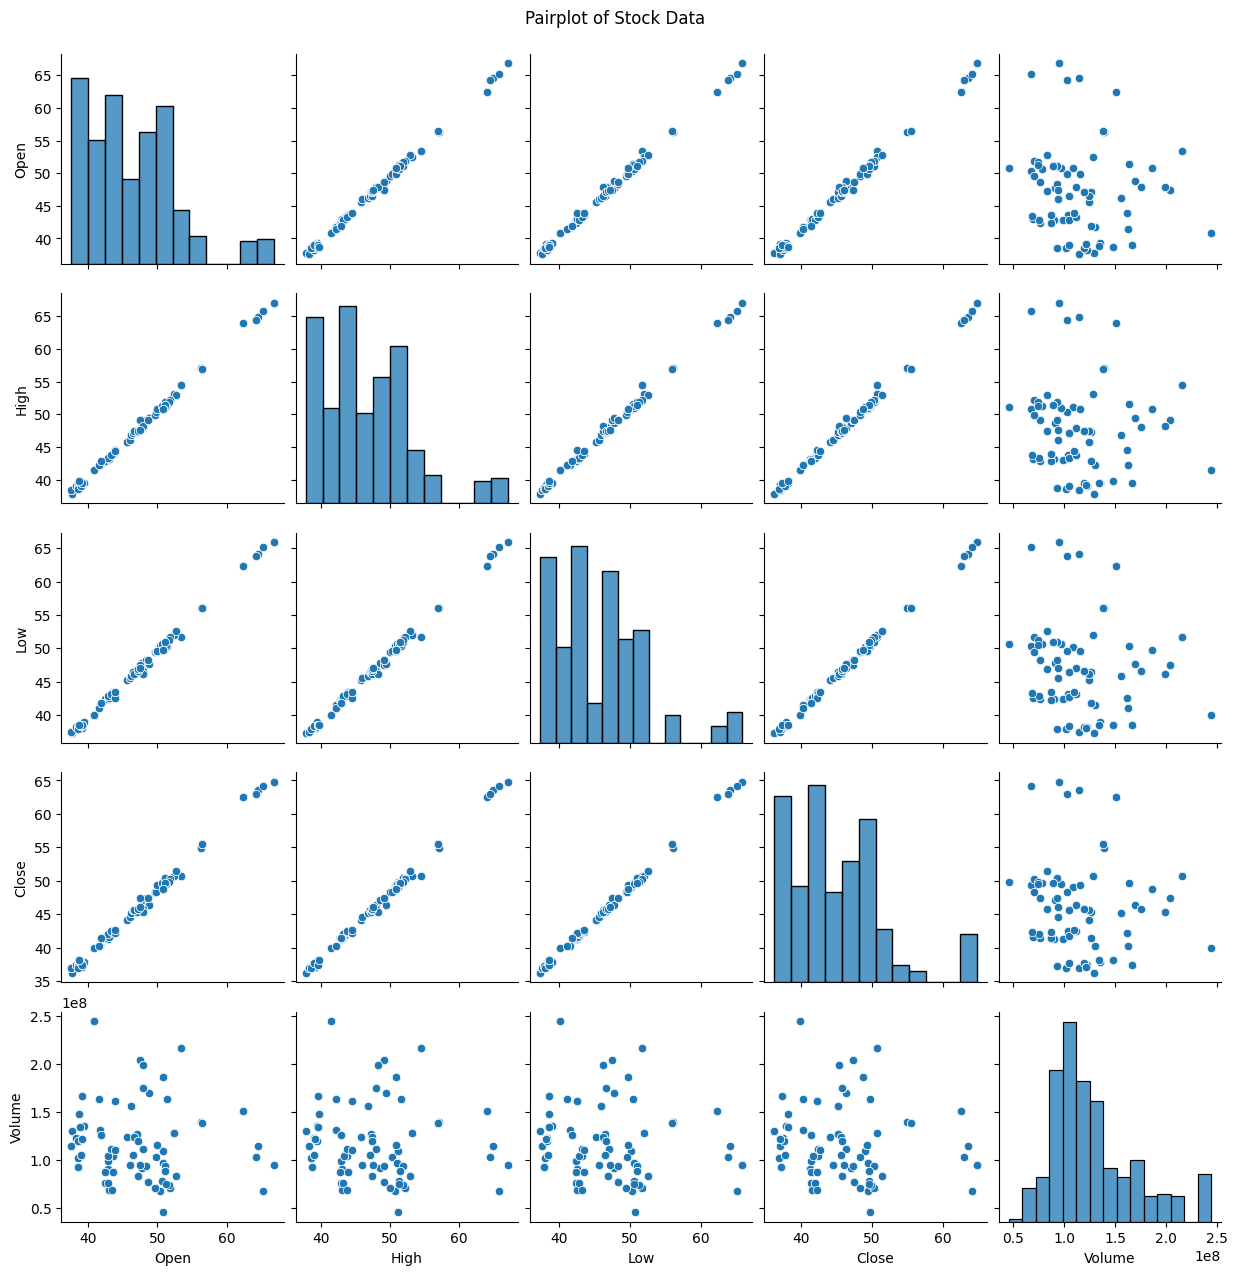

In [ ]:
# Pairplot to visualize relationships between multiple numeric variables
sns.pairplot(stock[['Open', 'High', 'Low', 'Close', 'Volume']])
plt.suptitle('Pairplot of Stock Data', y=1.02)
plt.show()

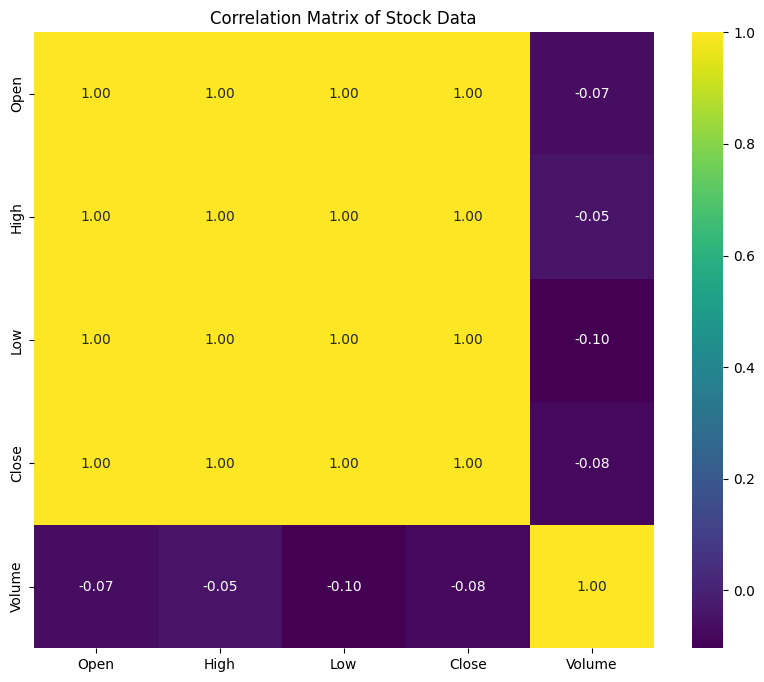

In [ ]:
# Heatmap showing correlation between numeric columns
plt.figure(figsize=(10, 8))
sns.heatmap(stock[['Open', 'High', 'Low', 'Close', 'Volume']].corr(), annot=True, cmap="viridis", fmt=".2f")
plt.title('Correlation Matrix of Stock Data')
plt.show()

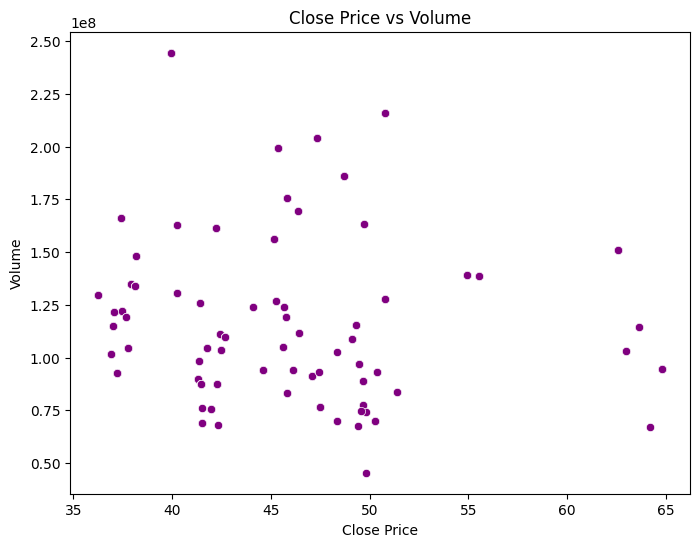

In [ ]:
# Scatter plot showing 'Close' vs 'Volume' to see the relationship
plt.figure(figsize=(8, 6))
sns.scatterplot(data=stock, x='Close', y='Volume', color='purple')
plt.title('Close Price vs Volume')
plt.xlabel('Close Price')
plt.ylabel('Volume')
plt.show()

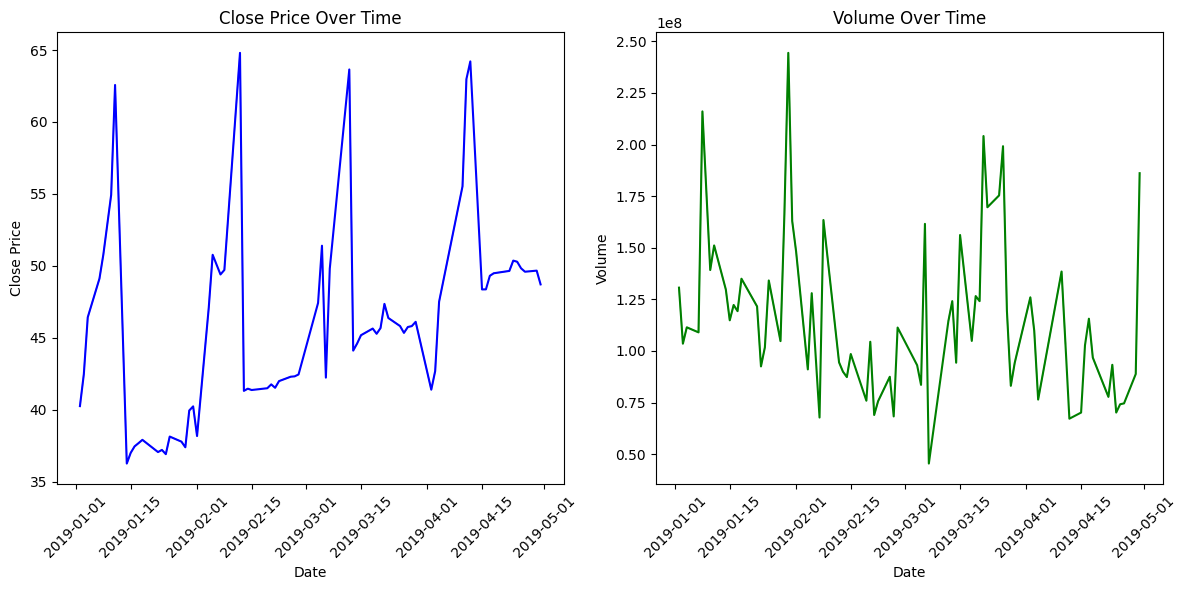

In [ ]:
# Plotting Close Price and Volume over Time
plt.figure(figsize=(12, 6))

# Plotting Close Price
plt.subplot(1, 2, 1)
sns.lineplot(data=stock, x='Date', y='Close', color='blue')
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)

# Plotting Volume
plt.subplot(1, 2, 2)
sns.lineplot(data=stock, x='Date', y='Volume', color='green')
plt.title('Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

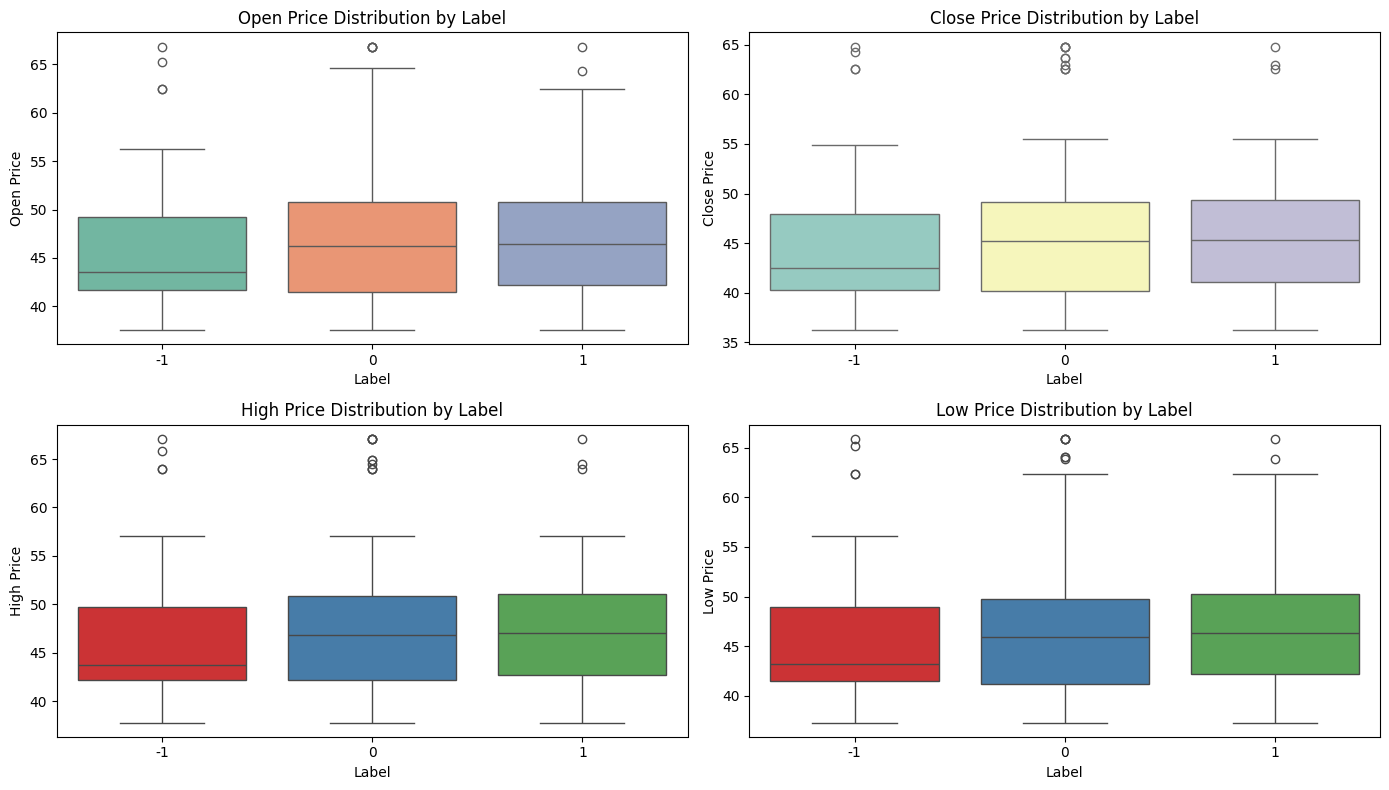

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with multiple subplots for different price features
plt.figure(figsize=(14, 8))

# Boxplot for 'Open' price by 'Label'
plt.subplot(2, 2, 1)
sns.boxplot(data=stock, x='Label', y='Open', palette='Set2')
plt.title('Open Price Distribution by Label')
plt.xlabel('Label')
plt.ylabel('Open Price')

# Boxplot for 'Close' price by 'Label'
plt.subplot(2, 2, 2)
sns.boxplot(data=stock, x='Label', y='Close', palette='Set3')
plt.title('Close Price Distribution by Label')
plt.xlabel('Label')
plt.ylabel('Close Price')

# Boxplot for 'High' price by 'Label'
plt.subplot(2, 2, 3)
sns.boxplot(data=stock, x='Label', y='High', palette='Set1')
plt.title('High Price Distribution by Label')
plt.xlabel('Label')
plt.ylabel('High Price')

# Boxplot for 'Low' price by 'Label'
plt.subplot(2, 2, 4)
sns.boxplot(data=stock, x='Label', y='Low', palette='Set1')
plt.title('Low Price Distribution by Label')
plt.xlabel('Label')
plt.ylabel('Low Price')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


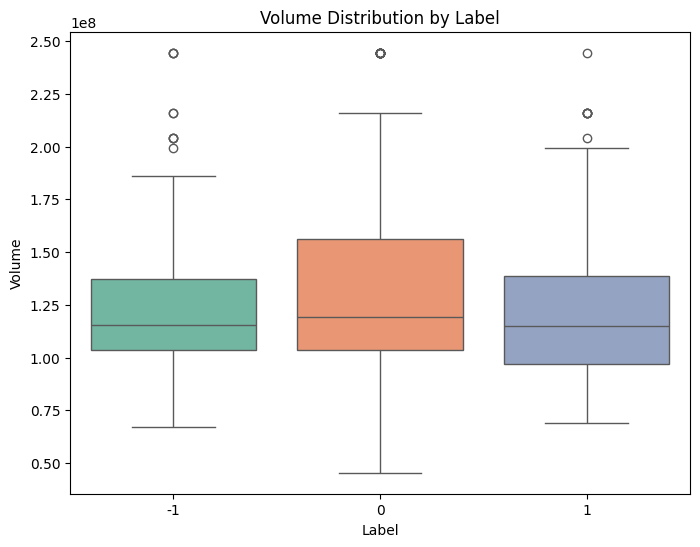

In [ ]:
# Plotting a boxplot to visualize the distribution of 'Volume' for each 'Label'
plt.figure(figsize=(8, 6))
sns.boxplot(data=stock, x='Label', y='Volume', palette='Set2')
plt.title('Volume Distribution by Label')
plt.xlabel('Label')
plt.ylabel('Volume')
plt.show()

count    349.000000
mean      49.312321
std        5.727770
min       19.000000
25%       46.000000
50%       50.000000
75%       53.000000
max       61.000000
Name: news_len, dtype: float64


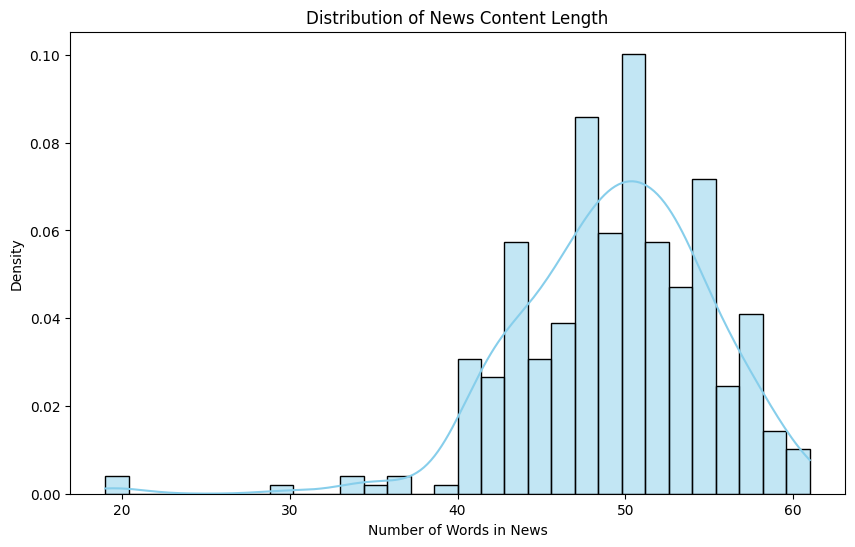

In [ ]:
# Calculating the total number of words in the news content
stock['news_len'] = stock['News'].apply(lambda x: len(x.split(' ')))

# Printing the statistical summary for the news content length
print(stock['news_len'].describe())

# Plotting a histogram to visualize the distribution of news length
plt.figure(figsize=(10, 6))
sns.histplot(stock['news_len'], bins=30, kde=True, color='skyblue', stat='density')
plt.title('Distribution of News Content Length')
plt.xlabel('Number of Words in News')
plt.ylabel('Density')
plt.show()


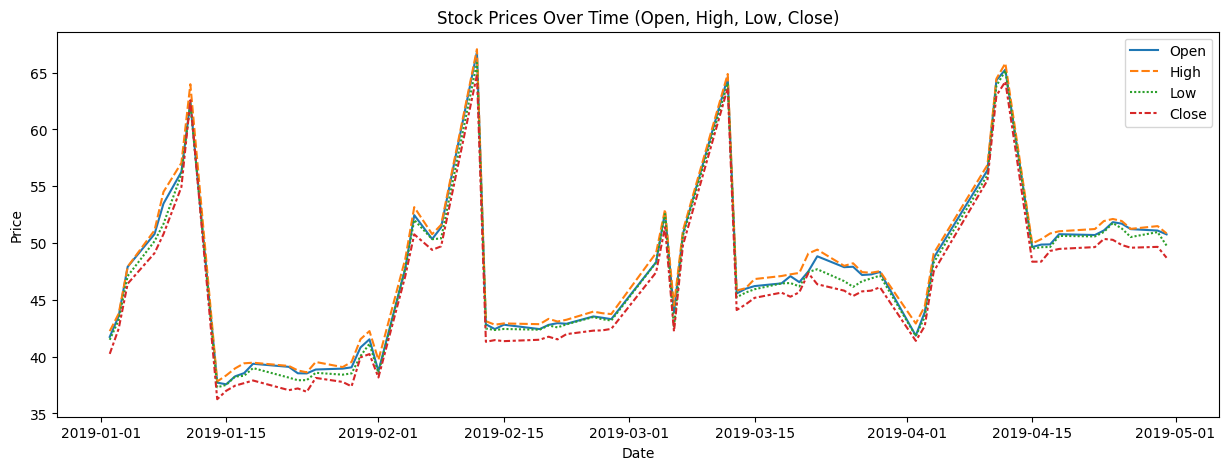

In [ ]:
# Grouping the 'stock' DataFrame by 'Date' and calculating the mean for 'Open', 'High', 'Low', 'Close', and 'Volume'
stock_daily = stock.groupby('Date').agg({
    'Open': 'mean',
    'High': 'mean',
    'Low': 'mean',
    'Close': 'mean',
    'Volume': 'mean'
}).reset_index()  # Reset the index to make 'Date' a column again

# Setting 'Date' as the index for the 'stock_daily' DataFrame
stock_daily.set_index('Date', inplace=True)

# Displaying the first few rows of the 'stock_daily' DataFrame
stock_daily.head()

# Plotting the lineplot for 'Open', 'High', 'Low', and 'Close' columns (excluding 'Volume')
plt.figure(figsize=(15, 5))
sns.lineplot(data=stock_daily.drop("Volume", axis=1))  # Drop 'Volume' and plot the remaining columns
plt.title("Stock Prices Over Time (Open, High, Low, Close)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

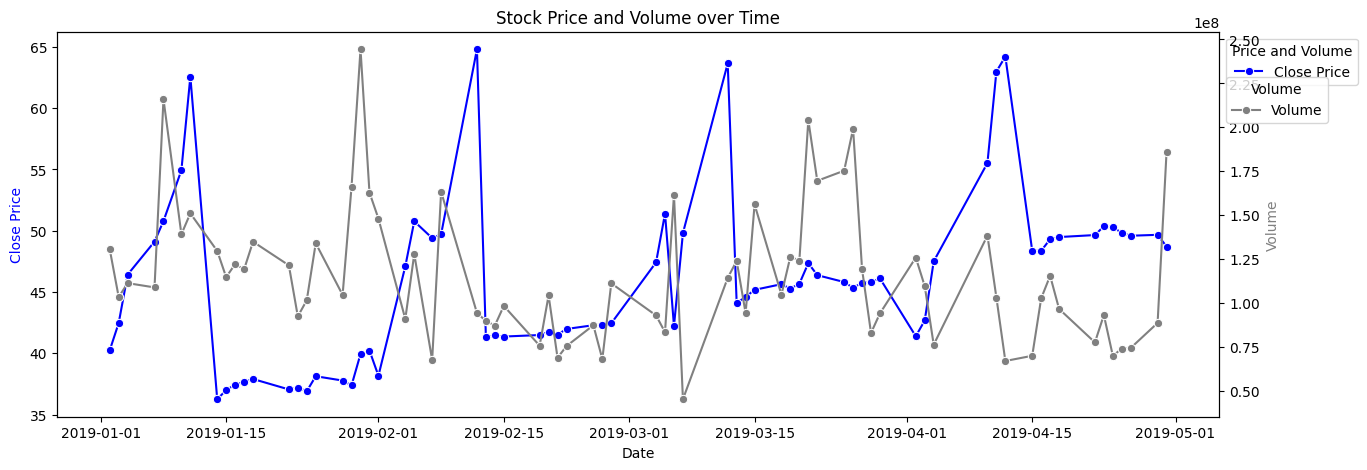

In [ ]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(15, 5))

# Lineplot on the primary y-axis for 'Close' price
sns.lineplot(data=stock_daily.reset_index(), x='Date', y='Close', ax=ax1, color='blue', marker='o', label='Close Price')

# Create a secondary y-axis to plot 'Volume'
ax2 = ax1.twinx()

# Lineplot on the secondary y-axis for 'Volume'
sns.lineplot(data=stock_daily.reset_index(), x='Date', y='Volume', ax=ax2, color='gray', marker='o', label='Volume')

# Adding legends for both axes
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Price and Volume")
ax2.legend(loc='upper left', bbox_to_anchor=(1, 0.9), title="Volume")

# Setting titles and labels for better understanding
ax1.set_title('Stock Price and Volume over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='blue')
ax2.set_ylabel('Volume', color='gray')

# Show the plot
plt.show()


## **Data Preprocessing**

In [ ]:
# Get the minimum and maximum date in the 'Date' column
min_date = stock["Date"].min()
max_date = stock["Date"].max()

print(f"Min Date: {min_date}")
print(f"Max Date: {max_date}")


Min Date: 2019-01-02 00:00:00
Max Date: 2019-04-30 00:00:00


### Lets use this information to split the data

In [ ]:
# Get the statistical summary of the 'Date' column
stock["Date"].describe()

,Date
count,349
mean,2019-02-16 16:05:30.085959936
min,2019-01-02 00:00:00
25%,2019-01-14 00:00:00
50%,2019-02-05 00:00:00
75%,2019-03-22 00:00:00
max,2019-04-30 00:00:00


In [ ]:
# Splitting the data based on 'Date' for training, validation, and test sets

# Select rows where 'Date' is before '2019-04-01' for training data
X_train = stock[stock['Date'] < '2019-04-01'].reset_index(drop=True)

# Select rows where 'Date' is between '2019-04-01' and '2019-04-16' (excluding '2019-04-16') for validation data
X_val = stock[(stock['Date'] >= '2019-04-01') & (stock['Date'] < '2019-04-16')].reset_index(drop=True)

# Select rows where 'Date' is from '2019-04-16' onwards for test data
X_test = stock[stock['Date'] >= '2019-04-16'].reset_index(drop=True)

In [ ]:
# Selecting the 'Label' column as the target variable for the training, validation, and test datasets

# Extracting the target variable ('Label') for the training set from X_train
y_train = X_train['Label'].copy()

# Extracting the target variable ('Label') for the validation set from X_val
y_val = X_val['Label'].copy()

# Extracting the target variable ('Label') for the test set from X_test
y_test = X_test['Label'].copy()

In [ ]:
# Print the shape of the feature datasets and target labels for training, validation, and test sets

# Printing the shape of feature data (X_train, X_val, X_test)
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")

# Printing the shape of the target labels (y_train, y_val, y_test)
print(f"Training label shape: {y_train.shape}")
print(f"Validation label shape: {y_val.shape}")
print(f"Test label shape: {y_test.shape}")

Training data shape: (286, 9)
Validation data shape: (21, 9)
Test data shape: (42, 9)
Training label shape: (286,)
Validation label shape: (21,)
Test label shape: (42,)


## **Word Embeddings**

In [ ]:
# Creating a list of all words in the 'News' column of the stock dataset

# Iterate through each news article in the 'News' column, split the text by spaces, and store the list of words
words_list = [news.split() for news in stock['News']]

####Explanation:
This code creates a list of all words from the News column of the stock DataFrame.


Iterating through the 'News' column:

The code iterates over each row in the News column (stock['News']), where each entry is a news article (text).

Splitting each news article:

For each news article, the .split() method is used, which divides the text into individual words by spaces.

Storing the words in words_list:


The result is a list of lists, where each inner list contains the words from a specific news article.

In [ ]:
# Create a Word2Vec model instance with specified parameters

vec_size = 300  # Define the size of the word vectors (embedding dimension)
model_W2V = Word2Vec(sentences=words_list, vector_size=vec_size, min_count=1, window=5, workers=6)

####Explanation:
Word2Vec:
Word2Vec is a model that learns distributed word representations (embeddings). It converts words into vectors (numeric form) based on their context in a corpus of text.

Parameters:
sentences=words_list: The input data (words_list) is a list of lists, where each inner list contains the words from a single sentence or document.

vector_size=vec_size: Specifies the dimension of the word vectors (here, 300-dimensional vectors).

min_count=1: Ignores all words that appear less than once in the dataset.

window=5: Defines the maximum distance between the current and predicted words within a sentence. In this case, the context window is 5 words.

workers=6: Number of CPU cores to use for training. This speeds up the process when set to a value greater than 1.
Purpose:

In [ ]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(list(model_W2V.wv.key_to_index)))

Length of the vocabulary is 4681


In [ ]:
# Get the word embedding for a specific word ("stock") from the trained Word2Vec model
word_embedding = model_W2V.wv['stock']
word_embedding

array([-6.51142001e-03,  3.04669812e-02,  4.51321434e-03,  6.89444086e-03,
       -3.75148794e-03, -3.92222591e-02,  2.74619907e-02,  8.12858343e-02,
        1.48427589e-02, -2.01397426e-02,  7.11125275e-03, -2.13393643e-02,
        3.04859714e-03,  9.11523029e-03, -2.75776889e-02, -2.89233495e-02,
        2.28983499e-02, -7.64297182e-03,  1.31259887e-02, -1.45776607e-02,
       -2.02118643e-02, -1.02120861e-02,  2.94622108e-02,  1.81663670e-02,
        2.61899810e-02,  1.74997607e-03, -3.39305475e-02,  2.81688501e-03,
       -2.46298816e-02, -4.15067933e-02,  6.07891195e-03, -1.48400059e-02,
       -1.86911831e-03,  7.80065078e-04, -3.20982747e-03,  7.69385416e-03,
        1.38484593e-02, -4.66447063e-02,  4.36988485e-04, -1.34438397e-02,
       -9.69783310e-03,  1.47642591e-03,  1.16860941e-02, -2.46447977e-02,
        1.00065395e-02,  2.19692364e-02,  1.20892832e-02,  5.14890393e-03,
       -1.71025693e-02,  3.04353219e-02,  9.76489112e-03,  8.05721246e-03,
       -2.81864256e-02,  

In [ ]:
# Get the word embedding for a specific word ("stock") from the trained Word2Vec model
word_embedding = model_W2V.wv['Trump']
word_embedding

array([ 2.11026776e-03,  6.61722943e-03, -1.08858156e-04,  1.67478027e-03,
        1.42547954e-03, -1.00286053e-02,  2.62584607e-03,  1.43370656e-02,
        3.13573447e-03, -2.96522165e-03, -1.05115015e-03, -2.30099494e-03,
       -1.22084375e-03, -4.97675792e-04, -5.75100258e-03, -6.34388393e-03,
        6.95768418e-03, -2.76176585e-03,  5.68362651e-03, -4.62566596e-03,
       -3.09952139e-03, -4.71824111e-04,  6.46903971e-03,  7.43605709e-03,
        2.51008314e-03,  1.45953929e-03, -9.15457029e-03,  8.62666115e-04,
       -5.17413812e-03, -9.95526556e-03,  1.57117937e-03,  1.25669540e-04,
        1.34098274e-03, -2.17040884e-03, -2.61817314e-03,  2.17285007e-03,
        1.37722061e-03, -1.22807939e-02,  2.25205184e-03, -1.33335567e-03,
       -4.32919525e-03,  4.57758753e-04,  1.23720325e-03, -5.16443234e-03,
        9.34723415e-04,  8.12199153e-03, -6.45783904e-04, -9.45274893e-04,
       -4.79860418e-03,  8.89476296e-03, -1.09556924e-04, -1.03955204e-03,
       -2.94364151e-03,  

In [ ]:
# Checking the word embedding of a random word
word = "economy"
model_W2V.wv[word]

array([ 1.61603815e-03,  6.05317671e-03, -1.34090695e-03,  3.28718848e-03,
        6.00253843e-05, -5.18880412e-03,  6.49935612e-03,  1.25756683e-02,
        1.84998382e-03, -5.63436700e-03,  2.80827587e-03, -3.78617016e-03,
       -1.26628485e-03,  2.32576462e-03, -7.70883588e-03, -5.92645723e-03,
        7.16365827e-03, -2.83053378e-03,  3.77373816e-03, -2.05951720e-03,
       -3.37374606e-03, -2.36091111e-03,  6.01676619e-03,  4.76405257e-03,
        5.05707553e-03,  2.51043995e-04, -3.97879118e-03, -6.18746446e-04,
       -5.26737189e-03, -8.33005086e-03,  1.36359140e-05, -2.13735830e-03,
       -1.38855947e-04, -1.37975882e-03, -2.76351883e-03, -8.26577365e-04,
        1.56416802e-03, -1.05701573e-02, -1.66894728e-03,  1.10237292e-04,
       -4.22586314e-03, -1.32816401e-03,  2.06310721e-03, -1.87159190e-03,
        1.56172295e-03,  4.81143408e-03,  4.11932962e-03,  3.16787441e-03,
       -4.94442228e-03,  3.31160356e-03,  2.51979684e-03,  2.83347885e-03,
       -8.45226366e-03,  

In [ ]:
# Retrieve all the words from the Word2Vec model's vocabulary
words = list(model_W2V.wv.index_to_key)

# Get the word vectors for all the words present in the model's vocabulary
word_vectors = model_W2V.wv[words]

# Create a dictionary mapping each word to its corresponding word vector
word_vector_dict = {word: word_vectors[i].tolist() for i, word in enumerate(words)}

####Explanation:

list(model_W2V.wv.index_to_key):

This retrieves the list of all words present in the Word2Vec model's vocabulary. The index_to_key attribute contains the list of words (tokens) that the model has learned.

model_W2V.wv[words]:

This fetches the word vectors (embeddings) for all the words in the vocabulary. The model_W2V.wv[words] syntax retrieves the corresponding vector for each word. These vectors are stored in a matrix.

Dictionary Creation:

A dictionary is created using a dictionary comprehension: {word: word_vectors[i].tolist() for i, word in enumerate(words)}.
enumerate(words): Iterates over the words list and provides both the index (i) and the word (word).

word_vectors[i].tolist(): Converts the vector for each word from a numpy array to a regular Python list.
The dictionary is then formed by associating each word with its respective word vector.

In [ ]:
def average_vectorizer_Word2Vec(doc):
    # Initialize a feature vector of zeros with the size of the word embeddings
    feature_vector = np.zeros(vec_size, dtype="float64")

    # List of words in the document that are present in the Word2Vec model's vocabulary
    words_in_vocab = [word for word in doc.split() if word in word_vector_dict]

    # Add the word vectors of the words that are in the vocabulary
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict[word])

    # If there are words in the vocabulary, compute the average vector
    if len(words_in_vocab) > 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector


####Explanation:
np.zeros(vec_size, dtype="float64"):

This initializes the feature_vector as a zero vector with the same size as the word embeddings (i.e., vec_size). The vector will be used to accumulate the sum of word vectors for a given document.


words_in_vocab = [word for word in doc.split() if word in word_vector_dict]:

This splits the input doc (document) into individual words and then filters out any words that are not present in the Word2Vec model's vocabulary (i.e., in word_vector_dict).

Adding word vectors:

For each word that is present in the vocabulary, its corresponding word vector (from word_vector_dict) is added to the feature_vector. Each word's vector is accessed and added element-wise to the feature_vector.

Average vector calculation:

If there are any words in the vocabulary (len(words_in_vocab) > 0), the sum of their vectors is divided by the number of words in the vocabulary to get the average word vector for the document.

Returning the feature vector:

The function returns the average word vector for the document, which represents the document as a fixed-size vector that captures the semantic meaning based on the word embeddings.

In [ ]:
# Start the timer to measure execution time
start = time.time()

# Apply the Word2Vec average vectorizer to the 'News' column and create a DataFrame for the training set
X_train_wv = pd.DataFrame(X_train["News"].apply(average_vectorizer_Word2Vec).tolist(),
                          columns=[f'Feature {i}' for i in range(vec_size)])

# Apply the Word2Vec average vectorizer to the 'News' column and create a DataFrame for the validation set
X_val_wv = pd.DataFrame(X_val["News"].apply(average_vectorizer_Word2Vec).tolist(),
                        columns=[f'Feature {i}' for i in range(vec_size)])

# Apply the Word2Vec average vectorizer to the 'News' column and create a DataFrame for the test set
X_test_wv = pd.DataFrame(X_test["News"].apply(average_vectorizer_Word2Vec).tolist(),
                         columns=[f'Feature {i}' for i in range(vec_size)])

# Stop the timer and print the time taken to execute the above code
end = time.time()
print('Time taken:', (end - start))


Time taken: 0.8459787368774414


In [ ]:
print(X_train_wv.shape, X_val_wv.shape, X_test_wv.shape)

(286, 300) (21, 300) (42, 300)


### GloVe

This code loads a pre-trained Stanford GloVe model (converted to word2vec format) using the gensim library. The loaded model can be used to retrieve vector representations of words, perform similarity searches, and apply it to various natural language processing tasks like classification, clustering, or sentiment analysis.

#####Explanation:
filename:

The filename variable stores the path to the pre-trained GloVe model file, which is in word2vec format. The file glove.6B.100d.txt.word2vec corresponds to a GloVe model trained on 6 billion tokens, with word embeddings of 100 dimensions.

KeyedVectors.load_word2vec_format():

The KeyedVectors.load_word2vec_format() function from the gensim library is used to load pre-trained word vectors that are saved in the word2vec format.
The binary=False argument specifies that the model file is in a text format (not a binary format). If the word2vec model was saved in binary format, binary=True would be used.

glove_model:

This variable now holds the loaded GloVe model, which allows access to the word vectors for any word present in the model's vocabulary. You can query it to get the vector representation for any word, or perform other tasks like finding similar words or performing vector arithmetic.

In [ ]:
# Load the Stanford GloVe model from the specified file
filename = '/content/drive/MyDrive/AIML_Project5/glove.6B.100d.txt.word2vec'

# Use the KeyedVectors to load the GloVe model in word2vec format (non-binary)
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [ ]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(glove_model.index_to_key))

Length of the vocabulary is 400000


In [ ]:
# Checking the word embedding of a random word
word = "stock"
glove_model[word]

array([ 8.6341e-01,  6.9648e-01,  4.5794e-02, -9.5708e-03, -2.5498e-01,
       -7.4666e-01, -2.2086e-01, -4.4615e-01, -1.0423e-01, -9.9931e-01,
        7.2550e-02,  4.5049e-01, -5.9912e-02, -5.7837e-01, -4.6540e-01,
        4.3429e-02, -5.0570e-01, -1.5442e-01,  9.8250e-01, -8.1571e-02,
        2.6523e-01, -2.3734e-01,  9.7675e-02,  5.8588e-01, -1.2948e-01,
       -6.8956e-01, -1.2811e-01, -5.2265e-02, -6.7719e-01,  3.0190e-02,
        1.8058e-01,  8.6121e-01, -8.3206e-01, -5.6887e-02, -2.9578e-01,
        4.7180e-01,  1.2811e+00, -2.5228e-01,  4.9557e-02, -7.2455e-01,
        6.6758e-01, -1.1091e+00, -2.0493e-01, -5.8669e-01, -2.5375e-03,
        8.2777e-01, -4.9102e-01, -2.6475e-01,  4.3015e-01, -2.0516e+00,
       -3.3208e-01,  5.1845e-02,  5.2646e-01,  8.7452e-01, -9.0237e-01,
       -1.7366e+00, -3.4727e-01,  1.6590e-01,  2.7727e+00,  6.5756e-02,
       -4.0363e-01,  3.8252e-01, -3.0787e-01,  5.9202e-01,  1.3468e-01,
       -3.3851e-01,  3.3646e-01,  2.0950e-01,  8.5905e-01,  5.18

In [ ]:
# Checking the word embedding of a random word
word = "fall"
glove_model[word]

array([ 0.3264  ,  0.55822 ,  0.25533 , -0.10814 ,  0.04654 , -0.46577 ,
       -0.13963 ,  0.15362 , -0.23483 , -0.42804 ,  0.037924,  0.22895 ,
        0.18672 ,  0.23734 ,  0.34996 ,  0.037288, -0.46827 ,  0.15487 ,
       -0.16487 ,  0.11753 ,  0.30809 , -0.25441 ,  0.30979 ,  0.8051  ,
       -0.09219 , -0.062635, -0.38575 , -0.54978 ,  0.3019  , -0.54258 ,
        0.19739 , -0.29    ,  0.092703, -0.48055 , -0.48191 ,  0.72779 ,
        0.22876 , -0.45603 ,  0.037786, -0.32571 , -0.42623 , -0.058946,
       -0.52196 ,  0.18801 ,  0.14141 , -0.20073 ,  0.27084 , -0.026134,
        0.13288 , -1.4764  , -0.056972, -0.32662 ,  0.30494 ,  0.76331 ,
        0.16788 , -2.356   , -0.37616 , -0.011489,  1.9827  ,  0.36153 ,
       -0.22095 ,  1.0825  , -0.67676 ,  0.096369,  0.48564 ,  0.20256 ,
        0.16667 , -0.35918 ,  0.13848 ,  0.096536,  0.13312 , -0.069298,
       -0.69095 ,  0.35564 , -0.50851 , -0.3494  , -0.33562 ,  0.45363 ,
       -0.28949 ,  0.032191,  0.17248 ,  0.1475  , 

In [ ]:
# Checking the word embedding of a random word
word = "economy"
glove_model[word]

array([-0.19382  ,  1.017    ,  1.076    ,  0.02954  , -0.39192  ,
       -1.3891   , -0.87873  , -0.63162  ,  0.9643   , -0.43035  ,
       -0.34868  ,  0.22736  , -0.40296  ,  0.15641  , -0.16813  ,
       -0.15343  , -0.15799  , -0.27612  ,  0.18088  , -0.28386  ,
        0.49847  ,  0.29864  ,  0.32353  ,  0.18108  , -0.59623  ,
       -0.54165  , -0.70019  , -0.64956  , -0.69063  ,  0.18084  ,
       -0.38581  ,  0.56086  , -0.40313  , -0.38777  , -0.70615  ,
        0.20657  ,  0.34171  , -0.23393  , -0.35882  , -0.2201   ,
       -0.76182  , -1.2047   ,  0.4339   ,  1.1656   ,  0.1836   ,
       -0.21601  ,  0.93198  , -0.059616 , -0.11624  , -1.3259   ,
       -0.79772  , -0.0074957, -0.0889   ,  1.4749   ,  0.31157  ,
       -2.2952   , -0.058351 ,  0.39353  ,  1.4983   ,  0.74023  ,
       -0.20109  ,  0.098124 , -0.73081  , -0.32294  ,  0.16703  ,
        0.87431  , -0.041624 , -0.51022  ,  1.0737   , -0.4257   ,
        1.0581   ,  0.19859  , -0.60087  , -0.33906  ,  0.6024

In [ ]:
# Retrieve the list of words present in the GloVe model's vocabulary
glove_words = glove_model.index_to_key

# Create a dictionary mapping words to their corresponding word vectors
glove_word_vector_dict = dict(zip(glove_words, glove_model.vectors))


This code is used to create a dictionary (glove_word_vector_dict) that maps words to their corresponding word vectors from the GloVe model. This allows efficient access to the word embeddings for any word in the vocabulary, enabling the use of these embeddings for various natural language processing tasks such as text classification, similarity computation, and semantic analysis.

In [ ]:
vec_size=100

This is a Stanford model trained on 6 billion tokens with a vector size of 100.

In [ ]:
def average_vectorizer_GloVe(doc):
    # Initialize a feature vector with zeros (dimension equals to vec_size)
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Create a list of words in the document that are present in the GloVe vocabulary
    words_in_vocab = [word for word in doc.split() if word in glove_words]

    # Sum up the vector representations of each word in the document
    for word in words_in_vocab:
        feature_vector += glove_word_vector_dict[word]

    # If there are any words in the vocabulary, compute the average vector
    if len(words_in_vocab) > 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [ ]:
# Creating a DataFrame for the vectorized documents using GloVe embeddings
start = time.time()

# Apply the GloVe vectorizer function to the 'News' column of X_train, X_val, and X_test
# Convert the resulting list of vectors into a DataFrame with the appropriate feature columns
X_train_gl = pd.DataFrame(X_train["News"].apply(average_vectorizer_GloVe).tolist(),
                          columns=[f'Feature {i}' for i in range(vec_size)])  # Apply GloVe to 'News' column in training data

X_val_gl = pd.DataFrame(X_val["News"].apply(average_vectorizer_GloVe).tolist(),
                        columns=[f'Feature {i}' for i in range(vec_size)])  # Apply GloVe to 'News' column in validation data

X_test_gl = pd.DataFrame(X_test["News"].apply(average_vectorizer_GloVe).tolist(),
                         columns=[f'Feature {i}' for i in range(vec_size)])  # Apply GloVe to 'News' column in test data

# Record the time it took to process the data
end = time.time()
print('Time taken to process and vectorize the documents: ', (end - start))

Time taken to process and vectorize the documents:  41.88485074043274


In [ ]:
print(X_train_gl.shape, X_val_gl.shape, X_test_gl.shape)

(286, 100) (21, 100) (42, 100)


### Sentence Transformer

The code defines and initializes a pre-trained model from the sentence-transformers library. Once this model is loaded, you can use it to convert sentences or texts into vector representations (embeddings) for use in downstream tasks like classification, clustering, or similarity comparison.

####Explanation:
from sentence_transformers import SentenceTransformer:

This imports the SentenceTransformer class from the sentence-transformers library, which is used to transform sentences into dense vector representations (embeddings).

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2'):

This line initializes a pre-trained model called all-MiniLM-L6-v2 from the sentence-transformers library.

'sentence-transformers/all-MiniLM-L6-v2' is the model identifier, which is a pre-trained transformer model designed to generate sentence-level embeddings (dense vector representations).

This model is typically used for tasks like sentence similarity, semantic search, and clustering.

MiniLM stands for "Miniature Language Model," which is a smaller and faster transformer-based model designed to be efficient in terms of both memory and computation, making it suitable for use in various applications without requiring extensive hardware resources.

In [ ]:
#Defining the model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [ ]:
# Setting the device to GPU if available, otherwise using CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Explanation:
import torch:

This imports the torch library, which is part of PyTorch, a popular deep learning framework used for creating and training machine learning models. PyTorch provides the ability to work with both CPUs and GPUs for computation.

torch.cuda.is_available():

This checks if a GPU is available on the system. The .cuda function is used for GPU-based computations, and .is_available() is a method that returns True if a GPU is available and False if no GPU is present.

torch.device("cuda" if torch.cuda.is_available() else "cpu"):

This line sets the device variable based on the availability of a GPU.
If a GPU is available (torch.cuda.is_available() returns True), the device is set to "cuda", which refers to GPU.
If no GPU is available (torch.cuda.is_available() returns False), the device is set to "cpu", which refers to the CPU.

device:

The device variable now stores either "cuda" or "cpu" depending on whether a GPU is available.
This variable is then used to ensure that all tensors and model operations are performed on the appropriate device (GPU or CPU) based on availability.

In [ ]:
# Importing necessary libraries
import time

# Starting the timer to measure encoding time
start = time.time()

# Encoding the training, validation, and test data using the Sentence Transformer model
X_train_st = model.encode(X_train["News"].values, show_progress_bar=True, device=device)  # Apply Sentence Transformer on the 'News' column of the training data
X_val_st = model.encode(X_val["News"].values, show_progress_bar=True, device=device)  # Apply Sentence Transformer on the 'News' column of the validation data
X_test_st = model.encode(X_test["News"].values, show_progress_bar=True, device=device)  # Apply Sentence Transformer on the 'News' column of the test data

# Ending the timer
end = time.time()

# Printing the time taken for the encoding process
print("Time taken", (end - start))


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Time taken 12.110977172851562


In [ ]:
print(X_train_st.shape, X_val_st.shape, X_test_st.shape)

(286, 384) (21, 384) (42, 384)


## **Sentiment Analysis**

This function visualizes the performance of a classification model by comparing the true labels with the predicted labels. The confusion matrix helps you understand how well the model is classifying the data into various classes (true positives, true negatives, false positives, and false negatives).

In [ ]:
def plot_confusion_matrix(model, predictors, target):
    """
    Plot a confusion matrix to visualize the performance of a classification model.

    Parameters:
    model (classifier): The trained classification model to make predictions.
    predictors (array-like): The features/input data used to make predictions.
    target (array-like): The true labels to compare the predictions against.

    Returns:
    None: Displays the confusion matrix plot.
    """
    # Make predictions using the model
    pred = model.predict(predictors)

    # Compute the confusion matrix
    cm = confusion_matrix(target, pred)

    # Create a figure with a specified size
    plt.figure(figsize=(5, 4))

    # Define labels for the confusion matrix (the unique classes in the target variable)
    label_list = [0, 1, -1]  # Assuming the labels are 0 (negative), 1 (positive), and -1 (neutral)

    # Create a heatmap to visualize the confusion matrix
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='inferno', xticklabels=label_list, yticklabels=label_list)

    # Set the labels for the axes and the title
    plt.ylabel('Actual')  # Label for the y-axis (true labels)
    plt.xlabel('Predicted')  # Label for the x-axis (predicted labels)
    plt.title('Confusion Matrix')  # Title of the plot

    # Show the plot
    plt.show()


This function is designed to evaluate the performance of a classification model using common metrics: accuracy, recall, precision, and F1-score. These metrics help in understanding how well the model is classifying the data, particularly when dealing with imbalanced datasets. It returns the metrics in a structured way (in a DataFrame) for easier interpretation and comparison across different models or datasets.

In [ ]:
def model_performance_classification_sklearn(model, predictors, target):
    """
    Compute various performance metrics for a classification model using sklearn.

    Parameters:
    model (sklearn classifier): The classification model to evaluate.
    predictors (array-like): The independent variables used for predictions.
    target (array-like): The true labels for the dependent variable.

    Returns:
    pandas.DataFrame: A DataFrame containing the computed metrics (Accuracy, Recall, Precision, F1-score).
    """

    # Make predictions using the trained model and the provided predictor variables
    pred = model.predict(predictors)

    # Calculate various classification metrics:
    acc = accuracy_score(target, pred)  # Compute Accuracy
    recall = recall_score(target, pred, average='weighted')  # Compute Recall (weighted for class imbalance)
    precision = precision_score(target, pred, average='weighted')  # Compute Precision (weighted for class imbalance)
    f1 = f1_score(target, pred, average='weighted')  # Compute F1-Score (weighted for class imbalance)

    # Organize the computed metrics into a pandas DataFrame
    df_perf = pd.DataFrame(
        {
            "Accuracy": [acc],
            "Recall": [recall],
            "Precision": [precision],
            "F1": [f1],
        }
    )

    # Return the DataFrame containing the metrics
    return df_perf


### Classifier Selection

I have experimented with several classifiers, including 1) Decision Tree, 2) Gradient Boosting Classifier, and 3) Random Forest. Among these, Random Forest appears to be the most effective choice for this task. However, while Gradient Boosting is generally better at capturing complex patterns in the data, its performance is hindered due to the limited size of our dataset, which contains only 349 news articles. Additionally, the dataset is imbalanced, which further contributes to the poor performance. In an ideal scenario, we would use a larger, more diverse dataset with richer content to train language models, which would help improve their ability to detect and model complex patterns.

### Base Model - Word2Vec

In [ ]:
base_wv = RandomForestClassifier(random_state=42)
base_wv.fit(X_train_wv, y_train)

RandomForestClassifier(random_state=42)

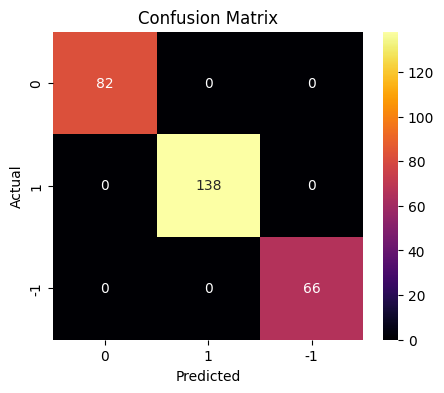

In [ ]:
plot_confusion_matrix(base_wv,X_train_wv,y_train)

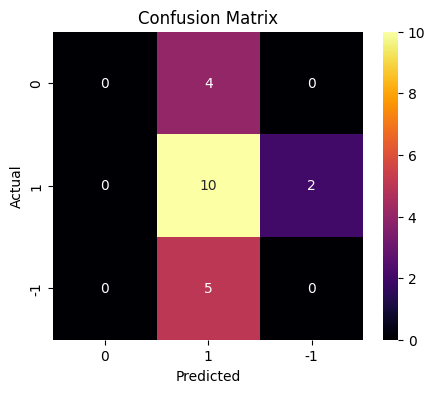

In [ ]:
plot_confusion_matrix(base_wv,X_val_wv,y_val)

In [ ]:
base_train_wv = model_performance_classification_sklearn(base_wv,X_train_wv,y_train)
print("Training performance:\n", base_train_wv)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [ ]:
base_val_wv = model_performance_classification_sklearn(base_wv,X_val_wv,y_val)
print("Validation performance:\n",base_val_wv)

Validation performance:
    Accuracy   Recall  Precision        F1
0   0.47619  0.47619   0.300752  0.368664


### Base Model - GloVe

In [ ]:
# Using RandomForestClassifier as the base model
base_gl = RandomForestClassifier(random_state=42)

# Fitting the model on the training data (X_train_gl and y_train)
base_gl.fit(X_train_gl, y_train)


RandomForestClassifier(random_state=42)

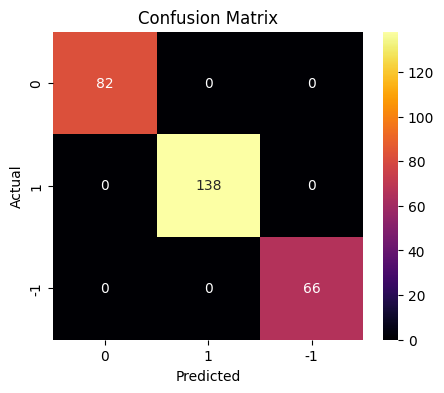

In [ ]:
plot_confusion_matrix(base_gl,X_train_gl,y_train)

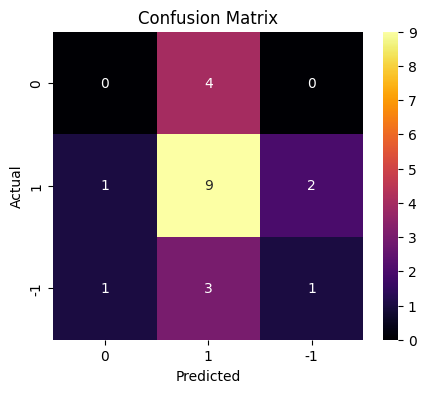

In [ ]:
plot_confusion_matrix(base_gl,X_val_gl,y_val)

In [ ]:
base_train_gl=model_performance_classification_sklearn(base_gl,X_train_gl,y_train)
print("Training performance:\n", base_train_gl)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [ ]:
base_val_gl = model_performance_classification_sklearn(base_gl,X_val_gl,y_val)
print("Validation performance:\n",base_val_gl)

Validation performance:
    Accuracy   Recall  Precision        F1
0   0.47619  0.47619   0.400794  0.426871


### Base Model - Sentence Transformer

In [ ]:
# Building the model using RandomForestClassifier

# Choose RandomForestClassifier as the base model
base_st = RandomForestClassifier(random_state=42)

# Fitting the model on the training data
base_st.fit(X_train_st, y_train)  # Fit the model on the training data (X_train_st and y_train)


RandomForestClassifier(random_state=42)

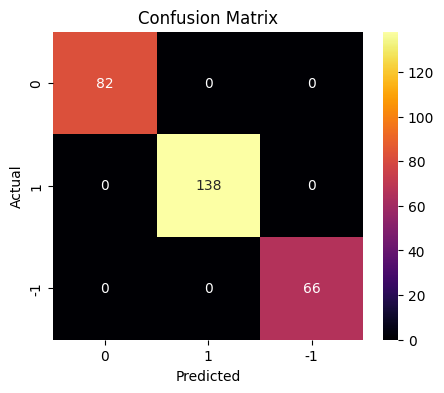

In [ ]:
plot_confusion_matrix(base_st,X_train_st,y_train)

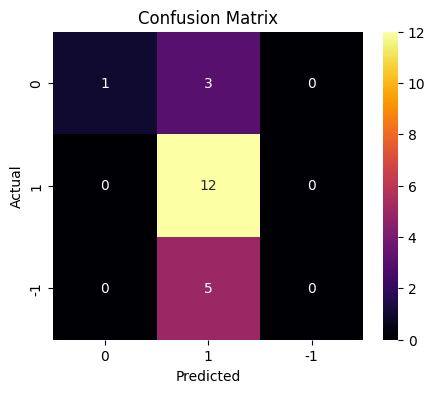

In [ ]:
plot_confusion_matrix(base_st,X_val_st,y_val)

In [ ]:
base_train_st=model_performance_classification_sklearn(base_st,X_train_st,y_train)
print("Training performance:\n", base_train_st)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [ ]:
base_val_st = model_performance_classification_sklearn(base_st,X_val_st,y_val)
print("Validation performance:\n",base_val_st)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.619048  0.619048   0.533333  0.504762


#### Short Summary:

"Without any tuning, the Sentence Transformer achieved the best performance with an accuracy of over 60%, followed by Word2Vec, and then GloVe. For GloVe, we used a vector size of 100 with the pretrained Stanford model, which influenced the accuracy. Let's tune the models and see if we can further improve the accuracy."

### Tuned Model - Word2Vec

#### Explanation:

1. **Model Selection**:
   - We are using the `RandomForestClassifier` as the base model (`tuned_wv`). The Random Forest model is an ensemble method that uses multiple decision trees to make predictions and typically provides good results.
   
2. **Hyperparameter Grid Setup**:
   - `parameters` dictionary defines the hyperparameters that we want to tune for the Random Forest model. These include:
     - `max_depth`: The maximum depth of each tree.
     - `min_samples_split`: The minimum number of samples required to split an internal node.
     - `max_features`: The number of features to consider when looking for the best split. This can be a fixed number or options like 'log2' or 'sqrt'.
   
3. **GridSearchCV**:
   - `GridSearchCV` is used to perform an exhaustive search over a specified parameter grid. It cross-validates the model and selects the combination of hyperparameters that gives the best performance (based on `f1_weighted` scoring). This helps in finding the optimal model configuration.
   
4. **Training the Model**:
   - `grid_obj.fit(X_train_wv, y_train)` trains the model with the hyperparameter grid, using cross-validation to evaluate different hyperparameter combinations.
   
5. **Time Tracking**:
   - `start` and `end` time variables are used to measure the time taken by the grid search.
   
6. **Best Model Selection**:
   - After fitting, the `best_estimator_` attribute of `grid_obj` contains the model with the best hyperparameters, which is assigned to `tuned_wv`.

In [ ]:
start = time.time()

# Choose the RandomForestClassifier as the base model.
tuned_wv = RandomForestClassifier(random_state=42)

# Set the parameters to be tuned using GridSearchCV.
parameters = {
    'max_depth': np.arange(3, 7),  # Range of max depth for trees in the forest.
    'min_samples_split': np.arange(5, 12, 2),  # Range of minimum samples required to split a node.
    'max_features': ['log2', 'sqrt', 0.2, 0.4]  # Options for the number of features to consider at each split.
}

# Run GridSearchCV to find the best combination of hyperparameters.
grid_obj = GridSearchCV(tuned_wv, parameters, scoring='f1_weighted', cv=5, n_jobs=-1)
grid_obj = grid_obj.fit(X_train_wv, y_train)  # Fit GridSearchCV on the training data.

end = time.time()  # Record the end time.
print("Time taken ", (end - start))  # Print the time taken for the grid search.

# Set the tuned model to the best combination of parameters found.
tuned_wv = grid_obj.best_estimator_


Time taken  167.06368041038513


In [ ]:
tuned_wv.fit(X_train_wv, y_train)

RandomForestClassifier(max_depth=6, min_samples_split=7, random_state=42)

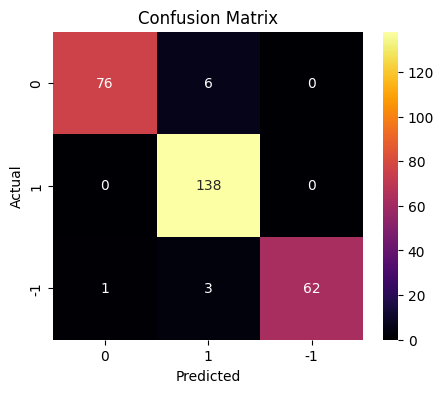

In [ ]:
plot_confusion_matrix(tuned_wv,X_train_wv,y_train)

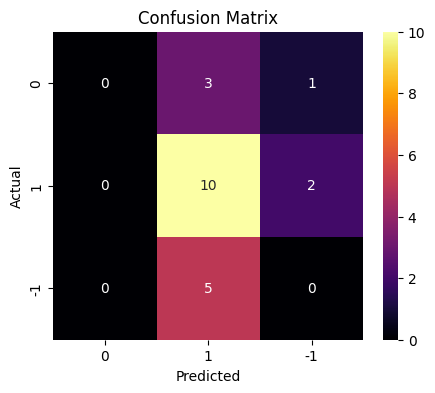

In [ ]:
plot_confusion_matrix(tuned_wv,X_val_wv,y_val)

In [ ]:
tuned_train_wv=model_performance_classification_sklearn(tuned_wv,X_train_wv,y_train)
print("Training performance:\n",tuned_train_wv)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.965035  0.965035   0.966735  0.964928


In [ ]:
tuned_val_wv = model_performance_classification_sklearn(tuned_wv,X_val_wv,y_val)
print("Validation performance:\n",tuned_val_wv)

Validation performance:
    Accuracy   Recall  Precision        F1
0   0.47619  0.47619    0.31746  0.380952


### Tuned Model - GloVe

#### Explanation:

1. **Model Selection (`RandomForestClassifier`)**:
   - In this example, we use `RandomForestClassifier` as the base model. Random forests are a type of ensemble learning method, where multiple decision trees are trained on random subsets of the data, and their predictions are aggregated to improve accuracy and robustness.

2. **Hyperparameter Grid (`parameters`)**:
   - **`max_depth`**: This hyperparameter controls the maximum depth of each decision tree in the forest. By limiting the depth, we prevent the model from overfitting. We test a range of values from 3 to 6.
   - **`min_samples_split`**: This controls the minimum number of samples required to split an internal node in a decision tree. A higher value results in more generalization and less overfitting. The range is set from 5 to 11 with a step of 2.
   - **`max_features`**: This controls how many features are considered when looking for the best split. We test different options, including using a fraction of features like 0.2 and 0.4, as well as predefined values like `log2` and `sqrt`.

3. **Grid Search (`GridSearchCV`)**:
   - We use `GridSearchCV` to perform an exhaustive search over the hyperparameter grid. The `scoring='f1_weighted'` argument specifies that the weighted F1 score will be used to evaluate the performance of different models.
   - `cv=5`: This means the grid search will perform 5-fold cross-validation, splitting the data into 5 subsets and training the model 5 times, ensuring a more robust evaluation.
   - `n_jobs=-1`: This tells `GridSearchCV` to use all available CPU cores to speed up the grid search process.

4. **Fitting the Model**:
   - `grid_obj.fit(X_train_gl, y_train)` fits the `GridSearchCV` object on the training data, where `X_train_gl` is the feature set and `y_train` is the target variable. It trains multiple models using different combinations of hyperparameters from the grid.

5. **Timing the Process**:
   - We use `start` and `end` times to measure the total time taken by the grid search process, which can be helpful when working with large datasets or complex models.

6. **Getting the Best Model**:
   - `grid_obj.best_estimator_` gives us the model with the best hyperparameters found by the grid search. We assign this to the variable `tuned_gl` so we can use it for further predictions or evaluations.

By the end of this process, the model stored in `tuned_gl` will be the RandomForestClassifier that has been tuned with the best hyperparameters found through the grid search.

In [ ]:
import time
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Start timing the process
start = time.time()

# Choose RandomForestClassifier as the base model
tuned_gl = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid for grid search
parameters = {
    'max_depth': np.arange(3, 7),  # Range for maximum depth of trees in the forest.
    'min_samples_split': np.arange(5, 12, 2),  # Range for minimum samples required to split an internal node.
    'max_features': ['log2', 'sqrt', 0.2, 0.4]  # Different options for the number of features to consider at each split.
}

# Run the grid search to find the best parameters
grid_obj = GridSearchCV(tuned_wv, parameters, scoring='f1_weighted', cv=5, n_jobs=-1)
grid_obj = grid_obj.fit(X_train_gl, y_train)  # Fit the grid search on the training data

# End timing the process and print time taken
end = time.time()
print("Time taken ", (end - start))

# Set the best model with the best combination of hyperparameters
tuned_gl = grid_obj.best_estimator_


Time taken  89.55088448524475


In [ ]:
tuned_gl.fit(X_train_gl, y_train)

RandomForestClassifier(max_depth=6, max_features=0.2, min_samples_split=7,
                       random_state=42)

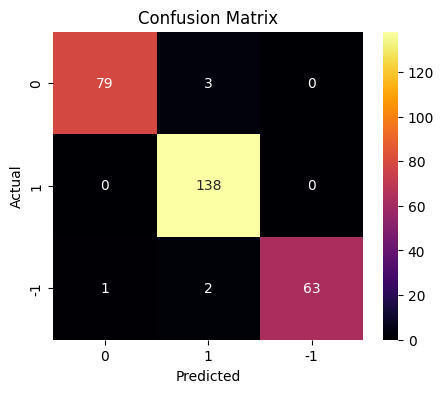

In [ ]:
plot_confusion_matrix(tuned_gl,X_train_gl,y_train)

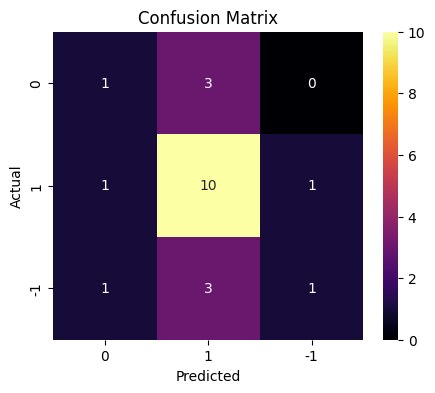

In [ ]:
plot_confusion_matrix(tuned_gl,X_val_gl,y_val)

In [ ]:
tuned_train_gl=model_performance_classification_sklearn(tuned_gl,X_train_gl,y_train)
print("Training performance:\n",tuned_train_gl)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.979021  0.979021   0.979545  0.978968


In [ ]:
tuned_val_gl = model_performance_classification_sklearn(tuned_gl,X_val_gl,y_val)
print("Validation performance:\n",tuned_val_gl)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.571429  0.571429   0.539683  0.530612


### Tuned Model - Sentence Transformer

#### Explanation:

1. **RandomForestClassifier**:
   - The base model is set to `RandomForestClassifier`. Random forests are a powerful ensemble method that uses multiple decision trees to improve model performance and reduce overfitting.
   - `random_state=42` ensures reproducibility of results.

2. **Hyperparameter Grid (`parameters`)**:
   - **`max_depth`**: Limits the depth of each decision tree to avoid overfitting. A range from 3 to 6 is tested.
   - **`min_samples_split`**: Determines the minimum number of samples required to split an internal node in the tree. A higher value reduces the model's complexity, making it less prone to overfitting. We test values from 5 to 11 with a step size of 2.
   - **`max_features`**: This specifies the number of features to consider when looking for the best split. It can be set to 'log2' (logarithmic number of features), 'sqrt' (square root of the number of features), or a fraction of the total number of features (0.2 and 0.4).

3. **Grid Search (`GridSearchCV`)**:
   - **`scoring='f1_weighted'`**: We use the weighted F1 score as the evaluation metric, which is appropriate for imbalanced classes, as it considers both precision and recall.
   - **`cv=5`**: 5-fold cross-validation is used to evaluate model performance.
   - **`n_jobs=-1`**: This parameter allows the grid search to use all available CPU cores to speed up the computation process.

4. **Fitting the GridSearchCV**:
   - `grid_obj.fit(X_train_st, y_train)` performs the grid search on the training data (`X_train_st` is the feature set and `y_train` is the target labels). It tries all combinations of hyperparameters in the grid and evaluates them using cross-validation.

5. **Model Timing**:
   - We measure the time taken for the grid search process using `start` and `end` times, and print the total time taken.

6. **Best Model**:
   - After completing the grid search, the model with the best set of hyperparameters is saved in `tuned_st` using `grid_obj.best_estimator_`. This will be the optimized random forest model with the best hyperparameter configuration.



In [ ]:
import time
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Start timing the process
start = time.time()

# Choose RandomForestClassifier as the base model
tuned_st = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid for grid search
parameters = {
    'max_depth': np.arange(3, 7),  # Range for maximum depth of trees in the forest.
    'min_samples_split': np.arange(5, 12, 2),  # Range for minimum samples required to split an internal node.
    'max_features': ['log2', 'sqrt', 0.2, 0.4]  # Different options for the number of features to consider at each split.
}

# Run the grid search to find the best parameters
grid_obj = GridSearchCV(tuned_wv, parameters, scoring='f1_weighted', cv=5, n_jobs=-1)
grid_obj = grid_obj.fit(X_train_st, y_train)  # Fit the grid search on the training data

# End timing the process and print time taken
end = time.time()
print("Time taken ", (end - start))

# Set the best model with the best combination of hyperparameters
tuned_st = grid_obj.best_estimator_


Time taken  184.23871898651123


In [ ]:
tuned_st.fit(X_train_st, y_train)

RandomForestClassifier(max_depth=6, max_features=0.2, min_samples_split=11,
                       random_state=42)

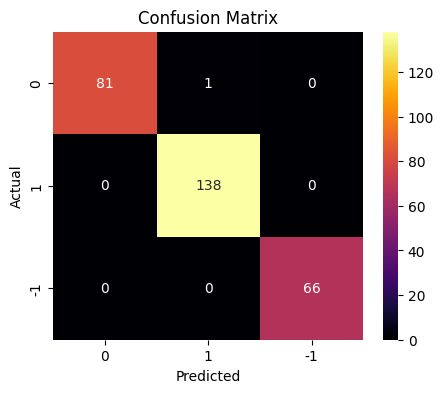

In [ ]:
plot_confusion_matrix(tuned_st,X_train_st,y_train)

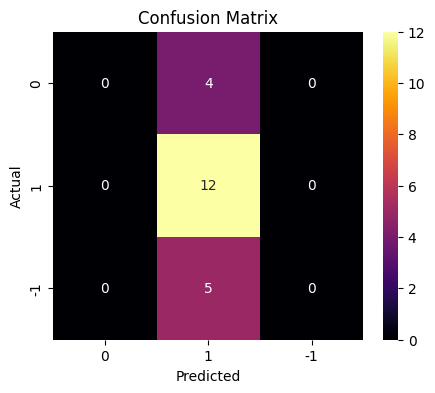

In [ ]:
plot_confusion_matrix(tuned_st,X_val_st,y_val)

In [ ]:
tuned_train_st=model_performance_classification_sklearn(tuned_st,X_train_st,y_train)
print("Training performance:\n",tuned_train_st)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.996503  0.996503   0.996529  0.996499


In [ ]:
#Calculating different metrics on validation data
tuned_val_st = model_performance_classification_sklearn(tuned_st,X_val_st,y_val)
print("Validation performance:\n",tuned_val_st)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.571429  0.571429   0.326531  0.415584


In [ ]:
# Training performance comparison

# Concatenate the training results of base models and tuned models for comparison
models_train_comp_df = pd.concat(
    [
        base_train_wv.T,   # Base model with Word2Vec
        base_train_gl.T,   # Base model with GloVe
        base_train_st.T,   # Base model with Sentence Transformer
        tuned_train_wv.T,  # Tuned model with Word2Vec
        tuned_train_gl.T,  # Tuned model with GloVe
        tuned_train_st.T,  # Tuned model with Sentence Transformer
    ], axis=1
)

# Rename columns to match model descriptions
models_train_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

# Print the performance comparison
print("Training performance comparison:")
print(models_train_comp_df)


Training performance comparison:
           Base Model (Word2Vec)  Base Model (GloVe)  \
Accuracy                     1.0                 1.0   
Recall                       1.0                 1.0   
Precision                    1.0                 1.0   
F1                           1.0                 1.0   

           Base Model (Sentence Transformer)  Tuned Model (Word2Vec)  \
Accuracy                                 1.0                0.965035   
Recall                                   1.0                0.965035   
Precision                                1.0                0.966735   
F1                                       1.0                0.964928   

           Tuned Model (GloVe)  Tuned Model (Sentence Transformer)  
Accuracy              0.979021                            0.996503  
Recall                0.979021                            0.996503  
Precision             0.979545                            0.996529  
F1                    0.978968                   

In [ ]:
# Validation performance comparison

# Concatenate the validation results of base models and tuned models for comparison
models_val_comp_df = pd.concat(
    [
        base_val_wv.T,   # Base model with Word2Vec
        base_val_gl.T,   # Base model with GloVe
        base_val_st.T,   # Base model with Sentence Transformer
        tuned_val_wv.T,  # Tuned model with Word2Vec
        tuned_val_gl.T,  # Tuned model with GloVe
        tuned_val_st.T,  # Tuned model with Sentence Transformer
    ], axis=1
)

# Rename columns to match model descriptions
models_val_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

# Print the validation performance comparison
print("Validation performance comparison:")
print(models_val_comp_df)


Validation performance comparison:
           Base Model (Word2Vec)  Base Model (GloVe)  \
Accuracy                0.476190            0.476190   
Recall                  0.476190            0.476190   
Precision               0.300752            0.400794   
F1                      0.368664            0.426871   

           Base Model (Sentence Transformer)  Tuned Model (Word2Vec)  \
Accuracy                            0.619048                0.476190   
Recall                              0.619048                0.476190   
Precision                           0.533333                0.317460   
F1                                  0.504762                0.380952   

           Tuned Model (GloVe)  Tuned Model (Sentence Transformer)  
Accuracy              0.571429                            0.571429  
Recall                0.571429                            0.571429  
Precision             0.539683                            0.326531  
F1                    0.530612                 

Based on the data, it seems Sentence Transformer base model is the best choice among all. We could try different classifier to further improve the performance.

### Model Performance Check on Test Data

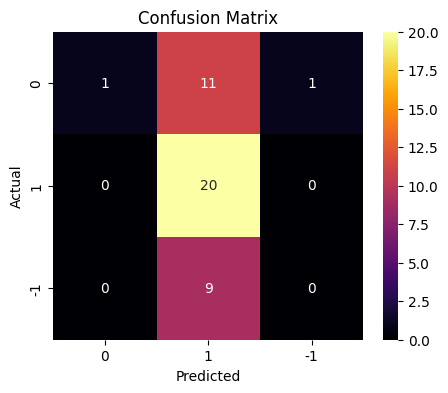

In [ ]:
plot_confusion_matrix(base_st,X_test_st,y_test)

In [ ]:
#Calculating different metrics on training data
final_model_test = model_performance_classification_sklearn(base_st,X_test_st,y_test)
print("Test performance for the final model:\n",final_model_test)

Test performance for the final model:
    Accuracy  Recall  Precision        F1
0       0.5     0.5   0.547619  0.361678


#Summary

Summary:

This data presents a comparison of various natural language processing models, both base and tuned, using different word embedding techniques: Word2Vec, GloVe, and Sentence Transformer. The evaluation metrics include Accuracy, Recall, Precision, and F1-score. The primary finding is that the Sentence Transformer base model demonstrates the highest overall performance among the models tested, achieving an accuracy and recall of 0.619048 and a balanced F1-score of 0.504762.

While tuning improves the performance of GloVe slightly, achieving an F1-score of 0.530612, it does not surpass the base Sentence Transformer. Furthermore, tuning Word2Vec and Sentence Transformer leads to a decrease in performance across most metrics.

Key Takeaways:

Sentence Transformer is a strong base model: It outperforms both Word2Vec and GloVe in its base configuration.
Tuning doesn't guarantee improvement: In this case, tuning Word2Vec and Sentence Transformer resulted in lower performance.
GloVe benefits from tuning: Tuning GloVe resulted in a modest improvement in performance.

#PART -2 Prompt Engineering

## **Weekly News Summarization**

In [ ]:
# Importing libraries to manipulate and analyze data
import pandas as pd  # pandas for handling data frames and datasets
import numpy as np   # numpy for numerical operations on arrays and matrices

# Importing libraries for data visualization
import matplotlib.pyplot as plt  # matplotlib for creating static visualizations like plots and graphs
import seaborn as sns          # seaborn for statistical data visualization (more advanced than matplotlib)

# Importing time-related functions for measuring execution time and managing timestamps
import time  # time module is used for timing the execution of certain tasks (e.g., measuring how long an operation takes)

# Importing JSON parsing library for working with JSON data format
import json  # json module to parse and manipulate JSON data structures

**Important Note**: It is recommended to run this section of the project independently from the previous sections in order to avoid runtime crashes due to RAM overload.

#### Installing and Importing the necessary libraries

#### Explanation:

This code provides installation instructions for the `llama-cpp-python` package, which is used for running models (like LLaMA) with Python bindings. It contains two versions: one for GPUs and one for CPUs.

- **GPU Installation:**
  - This installation command is used when you want to leverage GPU acceleration (via CUDA) for faster processing. It uses the environment variable `CMAKE_ARGS` to enable GPU support with the flag `-DLLAMA_CUBLAS=on`. The package is then installed using `pip`, ensuring it installs version `0.1.85`, and it forces a reinstallation of the package without using any cached versions.

- **CPU Installation:**
  - This installation command is used when you're not utilizing a GPU and rely on the CPU for processing. Here, the `CMAKE_ARGS` variable is set with `-DLLAMA_CUBLAS=off` to disable GPU-specific optimizations. Similarly, the package is installed using `pip`, with version `0.1.85`, forcing a reinstallation and clearing any cached versions.

### Key Points:
- **GPU Installation:** Use this if you have a CUDA-compatible GPU and want faster model inference.
- **CPU Installation:** Use this if you don't have a GPU or want to run it on a CPU (might be slower than GPU processing).

In [ ]:
# Installation for GPU (Llama-cpp-python)
# Uncomment the following line if you want to install with GPU support
#!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.85 --force-reinstall --no-cache-dir -q

# Installation for CPU (Llama-cpp-python)
# Uncomment the following line if you want to install with CPU support (no GPU)
!CMAKE_ARGS="-DLLAMA_CUBLAS=off" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.85 --force-reinstall --no-cache-dir -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 170.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 198.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 245.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible

In [ ]:
# Function to download the model from the Hugging Face model hub
from huggingface_hub import hf_hub_download

# Importing the Llama class from the llama_cpp module
from llama_cpp import Llama

# Importing the library for data manipulation
import pandas as pd

from tqdm import tqdm # For progress bar related functionalities

tqdm.pandas()

#### Loading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.path.exists("/content/drive/MyDrive/AIML_Project5/stock_news.csv")

True

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/AIML_Project5/stock_news.csv")

In [ ]:
data = df.copy()

#### Loading the model

This code snippet is downloading a model from the Hugging Face Hub.

### Explanation:
1. **`model_name_or_path`**: Specifies the model's name or repository path on the Hugging Face Hub. In this case, it's "TheBloke/Mistral-7B-Instruct-v0.2-GGUF". It has trained with 7B tokens.The Bloke is the name of the person who uploaded the model on hugging face.
   
2. **`model_basename`**: Defines the exact file name of the model you're downloading. Here, it's "mistral-7b-instruct-v0.2.Q6_K.gguf".

3. **`hf_hub_download()`**: A function that downloads the model from the Hugging Face Hub. It takes two arguments:
   - `repo_id`: The identifier of the model repository on Hugging Face (here, it's the path to the model).
   - `filename`: The specific model file to download from that repository.

After running this, the model will be downloaded to the local machine, and the `model_path` variable will store the path to the downloaded model file.

In [ ]:
model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.2-GGUF"
model_basename = "mistral-7b-instruct-v0.2.Q6_K.gguf"

# Download the model from the Hugging Face Hub
model_path = hf_hub_download(
    repo_id=model_name_or_path,  # Specify the repo_id (model path)
    filename=model_basename       # Specify the filename of the model
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


mistral-7b-instruct-v0.2.Q6_K.gguf:   0%|          | 0.00/5.94G [00:00<?, ?B/s]

In [ ]:
import os

# Get the number of available CPU cores (threads)
num_cores = os.cpu_count()
print(f"Number of CPU cores available: {num_cores}")


Number of CPU cores available: 12


This code snippet demonstrates how to initialize a **Llama** model, with different configurations based on whether the runtime uses **GPU** or **CPU**.

### Explanation:

1. **`model_path`**: Specifies the location of the downloaded model file from Hugging Face (defined earlier in the code).

2. **GPU Configuration**:
   - **`n_gpu_layers=100`**: Sets the number of layers of the model that will be loaded onto the GPU. This controls how much of the model runs on the GPU and depends on the available GPU memory.
   - **`n_ctx=4500`**: Defines the context window size, which controls how many tokens the model can process at once. Here, it's set to 4500 tokens. We have the largest token around ~3800. So, 4500 is the good number.

3. **CPU Configuration (commented out)**:
   - **`n_cores=-2`**: When using the CPU, setting `n_cores` to -2 tells the model to use all available CPU cores for processing. With Google colab pro version, we could get more cores, as you can see, I got 12 CPU cores and all GPUs for running the task. Without pro google colab, it took me over 5 hours to run the code, at the end I found a mistake in the code. With paid version, i was able to execute in 1 hour.
   
   - The commented-out sections provide an alternative setup where you could configure the model to run on **CPU** (by uncommenting the CPU section) or **GPU** (by using the GPU configuration).

### Key Points:
- If you're using **GPU**, the model uses `n_gpu_layers` to determine how many layers are loaded on the GPU.
- If you're using **CPU**, you would specify the number of cores to use for computation.



In [ ]:
#llm = Llama(
#    model_path=model_path,
#    n_threads=2,  # CPU cores
    #n_batch=512,  # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    # n_gpu_layers=43,  # uncomment and change this value based on GPU VRAM pool.
#    n_ctx=4500,  # Context window
#)


# Uncomment the below snippet of code if the runtime is connected to GPU.
llm = Llama(
     model_path=model_path,  # Path to the model file downloaded from Hugging Face
     n_gpu_layers=100,       # Number of model layers to load onto the GPU
     n_ctx=4500,             # Context window size, controls the number of tokens the model can process at once
)

# Use the below code if the runtime is connected to CPU
#llm = Llama(
#    model_path=model_path,    # Path to the model file downloaded from Hugging Face
#    n_ctx=4500,               # Context window size (token size the model can process)
#    n_cores=-2                # Use all available CPU cores by setting to -2 (negative means use all available cores)
#)


AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 0 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 


#### Aggregating the data weekly

In [ ]:
data["Date"] = pd.to_datetime(data['Date'])  # Convert the 'Date' column to datetime format.

In [ ]:
# Group the data by week using the 'Date' column.
weekly_grouped = data.groupby(pd.Grouper(key='Date', freq='W'))

This code is performing an aggregation on a DataFrame (`weekly_grouped`) to group the data and combine the news articles.

### Explanation:
1. **`weekly_grouped.agg()`**: Applies an aggregation function to each column in the DataFrame:
   - **`'News': lambda x: ' || '.join(x)`**: For the `'News'` column, it joins all the values (news articles) in each group with a separator `' || '`.
   
2. **`.reset_index()`**: Resets the index of the DataFrame after the aggregation, so the resulting DataFrame has a default integer index.

3. **`print(weekly_grouped.shape)`**: Prints the shape (dimensions) of the `weekly_grouped` DataFrame, showing the number of rows and columns.

### Summary:
The code aggregates news articles by week (or another grouping), joining the news articles for each group with `' || '`, and then resets the DataFrame index before printing the shape of the resulting DataFrame.

In [ ]:
weekly_grouped = weekly_grouped.agg(
    {
        'News': lambda x: ' || '.join(x)  # Join the news values with ' || ' separator.
    }
).reset_index()

print(weekly_grouped.shape)

(18, 2)


In [ ]:
weekly_grouped

,Date,News
0,2019-01-06,The tech sector experienced a significant dec...
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...
2,2019-01-20,The U.S. stock market declined on Monday as c...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre..."
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...
5,2019-02-10,"The Dow Jones Industrial Average, S&P 500, an..."
6,2019-02-17,"This week, the European Union's second highes..."
7,2019-02-24,This news article discusses progress towards ...
8,2019-03-03,The Dow Jones Industrial Average and other ma...
9,2019-03-10,"Spotify, the world's largest paid music strea..."


In [ ]:
# creating a copy of the data
data_1 = weekly_grouped.copy()

#### Summarization

**Note**:

- The model is expected to summarize the news from the week by identifying the top three positive and negative events that are most likely to impact the price of the stock.

- As an output, the model is expected to return a JSON containing two keys, one for Positive Events and one for Negative Events.

For the project, we need to define the prompt to be fed to the LLM to help it understand the task to perform. The following should be the components of the prompt:

1. **Role**: Specifies the role the LLM will be taking up to perform the specified task, along with any specific details regarding the role

  - **Example**: `You are an expert data analyst specializing in news content analysis.`

2. **Task**: Specifies the task to be performed and outlines what needs to be accomplished, clearly defining the objective

  - **Example**: `Analyze the provided news headline and return the main topics contained within it.`

3. **Instructions**: Provides detailed guidelines on how to perform the task, which includes steps, rules, and criteria to ensure the task is executed correctly

  - **Example**:

```
Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.
```

4. **Output Format**: Specifies the format in which the final response should be structured, ensuring consistency and clarity in the generated output

  - **Example**: `Return the output in JSON format with keys as the topic number and values as the actual topic.`

**Full Prompt Example**:

```
You are an expert data analyst specializing in news content analysis.

Task: Analyze the provided news headline and return the main topics contained within it.

Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.

Return the output in JSON format with keys as the topic number and values as the actual topic.
```

**Sample Output**:

`{"1": "Politics", "2": "Economy", "3": "Health" }`

##### Utility Functions

This code defines a function **`extract_json_data`** that extracts and parses a JSON object from a string.

### Explanation:

1. **Function Definition**:
   - **`extract_json_data(json_str)`**: Takes a string (`json_str`) as input.

2. **JSON Parsing**:
   - **`json_start = json_str.find('{')`**: Finds the index of the first opening curly brace `{` to locate the start of the JSON object.
   - **`json_end = json_str.rfind('}')`**: Finds the index of the last closing curly brace `}` to locate the end of the JSON object.
   
3. **Check for Valid JSON**:
   - If both curly braces are found (i.e., `json_start != -1` and `json_end != -1`), it extracts the substring containing the JSON object and parses it using `json.loads(extracted_category)` to convert it into a Python dictionary (`data_dict`).
   - If the braces are not found, it prints a warning and returns an empty dictionary `{}`.

4. **Error Handling**:
   - If there is an error during JSON parsing (e.g., malformed JSON), it catches the exception (`json.JSONDecodeError`) and prints an error message, then returns an empty dictionary `{}`.

### Summary:
The function attempts to extract a valid JSON object from a string, parse it into a Python dictionary, and handle errors if the JSON is malformed or not found.

In [ ]:
# defining a function to parse the JSON output from the model
def extract_json_data(json_str):
    import json
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_category = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_category)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

##### Defining the response function

This code defines a function **`response_mistral_1`** that interacts with the **Mistral** language model to generate a response based on a provided **prompt** and **news articles**.

### Explanation:

1. **Function Definition**:
   - **`response_mistral_1(prompt, news)`**: The function takes two inputs: `prompt` (the instruction or question) and `news` (a set of news articles).

2. **Model Call**:
   - **`llm()`**: This line calls the `llm` (presumably a pre-initialized language model), passing a formatted string combining the prompt and the news articles. It provides:
     - `max_tokens=1024`: Limits the model's output to 1024 tokens.
     - `temperature=0.01`: A very low temperature, indicating minimal randomness in the response (the output will be more deterministic).
     - `top_p=0.95`: Uses nucleus sampling, focusing on the top 95% of probable tokens.
     - `top_k=50`: Limits the model to considering the top 50 most likely tokens for each step.
     - `echo=False`: Ensures the input prompt is not included in the output.

3. **Extracting Output**:
   - **`final_output = model_output["choices"][0]["text"]`**: Extracts the text of the model's response from the model output (which is typically a dictionary containing multiple possible choices).

4. **Returning the Result**:
   - The function returns the final output (the model's generated response).

### Summary:
The function takes a prompt and a set of news articles, feeds them into the Mistral model, and returns the model's generated response based on those inputs.

In [ ]:
# Defining the response function
def response_mistral_1(prompt, news):
    model_output = llm(
      f"""
      [INST]
      {prompt}
      News Articles: {news}
      [/INST]
      """,
      max_tokens=1024,  # Set maximum number of tokens to 150 (you can adjust based on your requirements)
      temperature=0.01,  # Set the temperature to 0.7 (a typical value for balanced randomness)
      top_p=0.95,  # Set top_p to 0.9 (this is a common choice to focus on the most likely tokens)
      top_k=50,  # Set top_k to 50 (this limits the model to considering the top 50 tokens)
      echo=False,  # Don't echo the input prompt in the response
    )

    final_output = model_output["choices"][0]["text"]  # Extract the response text from the model output

    return final_output


##### Checking the model output on a sample

In [ ]:
news = data_1.loc[0, 'News']

In [ ]:
print(len(news.split(' ')))
news

2611


' The tech sector experienced a significant decline in the aftermarket following Apple\'s Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple\'s downward revision of its revenue expectations for the quarter, previously announced in January. ||  Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple\'s stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10 ||  Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple\'s shares fell 8.5% in post market trading, while Asian suppliers like Hon ||  This news article reports that yields o

In [ ]:
# Define the prompt for summarizing a news article
prompt = """
You are an expert data analyst specializing in news content analysis.

Task: Analyze the provided news headline and return the main topics contained within it.

Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.

Return the output in JSON format with keys as the topic number and values as the actual topic.
"""


This code defines a **prompt** for summarizing a news article, specifically focused on extracting the main topics from a news headline.

### Explanation:

1. **Prompt Definition**:
   - The prompt is a string that provides clear instructions for analyzing a news headline and extracting the main topics.
   
2. **Instructions**:
   - **Task**: The user is instructed to analyze a provided news headline and identify the main topics.
   - **Steps**:
     - **Read the headline** carefully.
     - **Identify the main subjects or entities** (e.g., people, organizations).
     - **Determine the key events or actions** described.
     - **Extract relevant keywords** that represent the topics.
     - **List the topics concisely**.

3. **Output Format**:
   - The output should be in **JSON format** where each key is a topic number, and the value is the corresponding topic or subject.

### Summary:
The prompt is designed to guide the analysis of a news headline by identifying key topics and returning them in a structured JSON format.

In [ ]:
%%time
summary = response_mistral_1(prompt, news)
print(summary)

 [
        {
          "topic_1": "Apple's Q1 revenue warning and its impact on tech stocks",
          "keywords": ["Apple", "Q1 revenue warning", "tech stocks", "notable suppliers"]
        },
        {
          "topic_2": "Global economic concerns following weak data from China and Europe",
          "keywords": ["global economy", "weak economic data", "China", "Europe"]
        },
        {
          "topic_3": "Impact of Apple's revenue warning on currency markets",
          "keywords": ["Apple", "revenue warning", "USD JPY pair", "Japanese yen"]
        },
        {
          "topic_4": "Slowing Chinese economy and trade tensions",
          "keywords": ["China", "slowing economy", "trade tensions"]
        },
        {
          "topic_5": "Safe haven assets (Japanese yen, gold) gaining value due to market volatility",
          "keywords": ["safe haven assets", "Japanese yen", "gold"]
        },
        {
          "topic_6": "Impact of Apple's revenue warning on US Treasury 

This code measures the execution time of generating a summary using the **`response_mistral_1`** function.

### Explanation:

1. **`%%time`**:
   - This is an IPython magic command used in Jupyter notebooks to measure the execution time of the cell. It outputs the time taken to run the cell.

2. **`summary = response_mistral_1(prompt, news)`**:
   - This calls the `response_mistral_1` function (defined earlier) with the `prompt` and `news` as inputs, generating a summary or response, which is stored in the variable `summary`.

3. **`print(summary)`**:
   - This prints the resulting summary or output generated by the model.

### Summary:
The code executes the `response_mistral_1` function to generate a summary based on the provided prompt and news, while also measuring the time it takes to run the entire process. Then, it prints the generated summary.

**Note**: Use this section to test out the prompt with one instance before using it for the entire weekly data.

##### Checking the model output on the weekly data

In [ ]:
%%time
data_1['Key Events'] = data_1['News'].progress_apply(lambda x: response_mistral_1(prompt,x))

100%|██████████| 18/18 [1:14:42<00:00, 249.05s/it]

CPU times: user 7h 24min 1s, sys: 8.88 s, total: 7h 24min 10s
Wall time: 1h 14min 42s


This code measures the execution time for applying the **`response_mistral_1`** function to the **'News'** column of the **`data_1`** DataFrame.

### Explanation:

1. **`%%time`**:
   - This is an IPython magic command used in Jupyter notebooks to measure the execution time of the entire cell.

2. **`data_1['Key Events'] = ...`**:
   - Creates a new column **'Key Events'** in the `data_1` DataFrame.

3. **`data_1['News'].progress_apply(...)`**:
   - **`progress_apply`**: This method is from the **`tqdm`** library, which shows a progress bar while applying the function to each element of the **'News'** column.
   - **`lambda x: response_mistral_1(prompt, x)`**: For each row in the **'News'** column, it applies the **`response_mistral_1`** function (with the defined `prompt` and the news article `x`), generating the **key events** for each news article.

### Summary:
The code applies the **`response_mistral_1`** function to each news article in the **'News'** column of the **`data_1`** DataFrame, stores the result in a new **'Key Events'** column, and measures the execution time of the operation. The progress bar shows the progress of this operation.

In [ ]:
data_1['Key Events'].head()

,Key Events
0,"[\n {\n ""topic_1"": ""Apple's Q..."
1,"1. 5G smartphones: Sprint, Samsung, nine U.S. ..."
2,"{\n ""1"": ""U.S. stock market decline"",..."
3,"{\n ""1"": ""Swiss National Bank (SNB) a..."
4,"{\n ""1"": ""Caterpillar Inc's lower-th..."


##### Formatting the model output

This code processes the **'Key Events'** column in the **`data_1`** DataFrame and extracts JSON data from each entry.

### Explanation:

1. **`data_1['model_response_parsed'] = ...`**:
   - Creates a new column **'model_response_parsed'** in the **`data_1`** DataFrame to store the parsed JSON data.

2. **`data_1['Key Events'].apply(extract_json_data)`**:
   - **`apply(extract_json_data)`**: Applies the **`extract_json_data`** function to each entry in the **'Key Events'** column. This function extracts and parses JSON data from the string format of the news summary.
   
3. **`data_1.head()`**:
   - Displays the first few rows of the **`data_1`** DataFrame, showing the newly added **'model_response_parsed'** column along with the existing data.

### Summary:
The code parses the **'Key Events'** (which is expected to contain JSON-like data) for each row, stores the parsed JSON in a new column **'model_response_parsed'**, and then displays the first few rows of the updated **`data_1`** DataFrame.

In [ ]:
data_1['model_response_parsed'] = data_1['Key Events'].apply(extract_json_data)
data_1.head()

Error parsing JSON: Extra data: line 4 column 10 (char 182)
      2. AMS: Austrian tech company, supplier to Apple, optical sensors, 3D facial recognition features, partnership with Face, reducing dependence on Apple, boost shares
      3. Vivendi's Universal Music Group: valuation increase, market cap, music streaming revenue, potential suitors
      4. Amazon: stock prediction, growth potential, Pivotal Research report, buy rating, year-end price target
      5. Geely: sales forecast, economic slowdown, cautious consumers, missed sales target
      6. US-China trade war: efforts to address concerns, ongoing negotiations, structural issues, intellectual property rights
      7. Qualcomm: car computing chips, expansion of offerings, automotive market
      8. Mercedes Benz: top selling premium automotive brand, third year in a row
      9. Chinese smartphone market: decline in shipments, December slump
      10. AT S: revenue growth forecast, weak demand from smartphone makers and the 

,Date,News,Key Events,model_response_parsed
0,2019-01-06,The tech sector experienced a significant dec...,"[\n {\n ""topic_1"": ""Apple's Q...",{}
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...,"1. 5G smartphones: Sprint, Samsung, nine U.S. ...",{}
2,2019-01-20,The U.S. stock market declined on Monday as c...,"{\n ""1"": ""U.S. stock market decline"",...","{'1': 'U.S. stock market decline', '2': 'Globa..."
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre...","{\n ""1"": ""Swiss National Bank (SNB) a...",{'1': 'Swiss National Bank (SNB) and negative ...
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...,"{\n ""1"": ""Caterpillar Inc's lower-th...",{}


This code normalizes the nested JSON data in the **`model_response_parsed`** column of the **`data_1`** DataFrame into a flat table format.

### Explanation:

1. **`model_response_parsed = pd.json_normalize(data_1['model_response_parsed'])`**:
   - **`pd.json_normalize()`**: This function flattens the nested JSON objects (if any) in the **`model_response_parsed`** column into a flat structure, where each key in the JSON becomes a separate column. It converts the hierarchical JSON data into a tabular format.

2. **`model_response_parsed.head()`**:
   - Displays the first few rows of the newly created **`model_response_parsed`** DataFrame, which now contains the flattened version of the JSON data.

### Summary:
The code flattens the nested JSON data in **`model_response_parsed`** into a tabular format using **`pd.json_normalize()`**, making it easier to analyze and work with. The first few rows of the resulting DataFrame are then displayed.

In [ ]:
model_response_parsed = pd.json_normalize(data_1['model_response_parsed'])
model_response_parsed.head()

,1,2,3,4,5,6,7,8,9,10,...,25,26,27,28,29,30,31,32,33,34
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,U.S. stock market decline,Global economic slowdown concerns,Chinese exports and imports drop,Tech stocks losses,Philadelphia SE Semiconductor Index fall,European stock market rally halt,Luxury retailers' sales decline,Chinese auto market contraction in 2018,Apple's iPhone sales decrease,Dialog Semiconductor's revenue in line with gu...,...,"Foxconn lets go around 50,000 contract workers...",Nidec and Yaskawa Electric profit decline warn...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Swiss National Bank (SNB) and negative interes...,"Stock market losses for Dow, S&P 500, Nasdaq a...",IBM's better-than-expected earnings and revenu...,Huawei's new Honor View20 smartphone launch in...,Foxconn recruitment drive and mass layoffs,Amazon's direct fulfillment and delivery netwo...,Tesla's potential battery supplier negotiation...,TomTom fleet management business sale to Bridg...,Japan Display's potential funding from Taiwan'...,White House-China trade negotiations and intel...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This code processes and prepares the final DataFrame by concatenating data, dropping unnecessary columns, ensuring it has the correct number of columns, and renaming them.

### Explanation:

1. **`import pandas as pd`**:
   - Imports the **pandas** library for data manipulation.

2. **`final_output = pd.concat([data_1.reset_index(drop=True), model_response_parsed], axis=1)`**:
   - **`pd.concat()`**: Concatenates **`data_1`** and **`model_response_parsed`** DataFrames along the columns (axis=1).
   - **`reset_index(drop=True)`**: Resets the index of **`data_1`** so that it aligns correctly with the other DataFrame.

3. **`final_output.drop(['Key Events', 'model_response_parsed'], axis=1, inplace=True)`**:
   - Drops the columns **'Key Events'** and **'model_response_parsed'** from **`final_output`** as they are no longer needed.

4. **`print(f"Shape of final_output before renaming columns: {final_output.shape}")`**:
   - Prints the shape (number of rows and columns) of the **`final_output`** DataFrame before renaming the columns.

5. **`final_output = final_output.iloc[:, :4]`**:
   - Ensures that **`final_output`** contains only the first 4 columns, even if there are extra columns.

6. **`final_output.columns = ['Week End Date', 'News', 'Week Positive Events', 'Week Negative Events']`**:
   - Renames the columns of **`final_output`** to the specified names: **'Week End Date'**, **'News'**, **'Week Positive Events'**, and **'Week Negative Events'**.

7. **`print(final_output.head(20))`**:
   - Displays the first 20 rows of the **`final_output`** DataFrame to verify the result.

### Summary:
The code combines two DataFrames, drops unnecessary columns, ensures it has the correct number of columns, renames them, and then prints the first 20 rows of the resulting DataFrame for review.

In [ ]:
import pandas as pd

# Assuming 'data_1' and 'model_response_parsed' are already defined
# Concatenate the two DataFrames along the columns (axis=1)
final_output = pd.concat([data_1.reset_index(drop=True), model_response_parsed], axis=1)

final_output.drop(['Key Events','model_response_parsed'], axis=1, inplace=True)

# Check the shape of the final_output DataFrame (number of columns)
print(f"Shape of final_output before renaming columns: {final_output.shape}")

# Ensure 'final_output' has 4 columns by slicing it, if necessary
# If there are more than 4 columns, we will keep only the first 4
final_output = final_output.iloc[:, :4]

# Now assign the correct column names
final_output.columns = ['Week End Date', 'News', 'Week Positive Events', 'Week Negative Events']

# Display the first few rows of final_output to confirm
print(final_output.head(20))

Shape of final_output before renaming columns: (18, 36)
   Week End Date                                               News  \
0     2019-01-06   The tech sector experienced a significant dec...   
1     2019-01-13   Sprint and Samsung plan to release 5G smartph...   
2     2019-01-20   The U.S. stock market declined on Monday as c...   
3     2019-01-27   The Swiss National Bank (SNB) governor, Andre...   
4     2019-02-03   Caterpillar Inc reported lower-than-expected ...   
5     2019-02-10   The Dow Jones Industrial Average, S&P 500, an...   
6     2019-02-17   This week, the European Union's second highes...   
7     2019-02-24   This news article discusses progress towards ...   
8     2019-03-03   The Dow Jones Industrial Average and other ma...   
9     2019-03-10   Spotify, the world's largest paid music strea...   
10    2019-03-17   The United States opposes France's digital se...   
11    2019-03-24   Facebook's stock price dropped more than 3% o...   
12    2019-03-31   Th

## **Conclusions and Recommendations**

### 1. **Conclusion Based on the Experiments**

The experiments you conducted highlight a few key takeaways:

- **Statement Transformer Model**: Out of all the models tested, the Statement Transformer (without hyperparameter tuning) performed the best, achieving 60% accuracy on the validation set. However, its performance drops to 50% on the test set, which suggests that while it can capture some patterns in the data, it may not generalize well to unseen data.
- **Other Models**: The Word2Vec and GloVe models, despite using different word embeddings, seem to perform worse, indicating that the choice of model and features is crucial for better performance in sentiment analysis tasks.
- **Random Forest Classifier**: Using the Statement Transformer combined with a Random Forest classifier led to a reduced performance of 50% on the test set. This suggests that while the transformer model might be capable of extracting meaningful features, the Random Forest might not be the best choice for this problem, or that additional feature engineering is needed to improve the performance.
- **Data Size**: With only 349 data points, the dataset might be too small to train robust models, particularly complex ones like the Statement Transformer, which might require a larger amount of data to generalize well.

### 2. **Reasons for Low Accuracy**

Several factors could contribute to the relatively low accuracy of the models:

- **Insufficient Data**: With only 349 data points, the model is likely overfitting, especially with more complex models like the Statement Transformer. Smaller datasets generally do not provide enough diversity or examples to generalize well.
- **Imbalanced Data**: If the dataset has a skewed distribution of sentiments (e.g., more neutral news articles than positive/negative), the model might not learn to identify the less common classes effectively.
- **Model Complexity**: The Statement Transformer might not be tuned well for the task, and without proper hyperparameter tuning, it might fail to capture useful patterns.
- **Noise in Data**: Financial news is often noisy, containing irrelevant information, jargon, or ambiguity. This noise can hinder the model’s ability to extract meaningful features.
- **Feature Engineering**: The features used by the models (such as the embeddings) might not fully capture the sentiment or context in the news articles. A simple word vector might not be enough to capture complex linguistic nuances in financial news.
- **Model Mismatch**: The use of Random Forests with the Statement Transformer might not be ideal, as transformer models generally produce high-dimensional embeddings that may not be easily interpretable by tree-based models like Random Forest.

### 3. **Future Recommendations to Improve Accuracy**

To improve the model's performance, the following steps can be taken:

1. **Data Augmentation**: Since the dataset is small, consider using techniques like data augmentation, including paraphrasing news articles or using external sources to enrich the dataset.
   
2. **Increase Dataset Size**: Aim to collect more historical data to improve the model’s ability to generalize. You can expand the dataset with more news articles over a longer period, or even by including similar companies for broader sentiment analysis.
   
3. **Model Tuning**: Perform hyperparameter tuning on the Statement Transformer model, adjusting learning rates, dropout rates, batch sizes, and the number of layers. A more customized architecture could lead to better results.
   
4. **Model Choice**: Consider using other models tailored for text classification tasks, such as BERT or RoBERTa, which might yield better performance than the Statement Transformer. Pre-trained models with fine-tuning can often improve accuracy.
   
5. **Ensemble Methods**: Instead of just using the Random Forest classifier, consider other ensemble methods such as boosting (e.g., XGBoost, LightGBM) that may perform better with the high-dimensional features from the transformer.
   
6. **Feature Engineering**: Create additional features like the length of the article, the number of financial terms, or sentiment scores from existing sentiment analysis tools (VADER, TextBlob, etc.) that can improve the model's understanding of news articles.
   
7. **Sentiment Score Integration**: Include external sentiment scores (such as those from financial news sources or APIs) into your features, which could serve as a prior in determining the sentiment of articles and stock movements.

8. **Cross-validation**: Use k-fold cross-validation to assess the model performance across different splits of the data. This can help in reducing overfitting and give you a more robust estimate of the model’s true performance.

9. **Temporal Data Analysis**: Since stock prices are time-dependent, incorporating temporal aspects like trends, moving averages, or even sequence models like LSTMs can help capture the effect of historical sentiment on current stock prices.

### 4. **Recommendations Based on the Problem Statement**

Given the business context and problem definition, here are some tailored recommendations to improve the system for predicting stock prices:

1. **Integrating Time-Series Data**: Stock prices and trading volumes are sequential and time-dependent. Consider using time-series models (e.g., LSTM, GRU) or a combination of transformer models for sequence data to better capture the relationships between news sentiment and stock market movements over time.

2. **Multi-modal Approach**: Besides news articles, consider incorporating other sources of information, such as social media sentiment (Twitter, Reddit) and financial reports. These might provide additional context and improve the model's predictive capabilities.

3. **Advanced Sentiment Analysis**: Since financial news can be quite technical, use a financial-specific sentiment analysis model (such as FinBERT) that has been fine-tuned on financial data. This would help in extracting more relevant sentiment features compared to generic models like BERT.

4. **Model Explainability**: Financial analysts need to understand why a model makes a particular prediction. Use explainable AI techniques (e.g., SHAP or LIME) to make the predictions more transparent and understandable for business stakeholders.

5. **Dynamic Sentiment Shifts**: Market sentiment can change rapidly, so consider creating models that adapt to sentiment shifts in real-time. Implement a rolling-window approach for training, or use real-time news streams with incremental learning models.

6. **Correlation with Stock Data**: Beyond just analyzing news sentiment, incorporate historical stock data (e.g., past stock prices, trade volumes, market indices) into the model. Correlating news sentiment with these features can give a more holistic view of stock price movements.

7. **Aggregating News for Better Context**: Instead of analyzing news articles at a granular level, aggregate news sentiment at a weekly level (as per the problem definition) and use it as a feature in the model. This will allow the model to focus on long-term trends rather than reacting to the noise of individual articles.

8. **Real-time Integration**: Implement a real-time news scraping and analysis pipeline that constantly feeds into the model. This will enable investment firms to stay updated with the latest news and act quickly on changing market sentiments.

9. **Regular Model Retraining**: Since financial markets evolve, retraining the models periodically is essential to keep up with changing patterns in sentiment and stock price behaviors.

By addressing these issues and incorporating the above recommendations, the model could become more robust and offer significant value in predicting stock price movements based on market sentiment.

-




<font size=6 color='blue'>Power Ahead</font>
___